# Importing libraries

In [1]:
from dabl import plot
from dabl.datasets import load_ames
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

## Loading the dataset

In [2]:
df = load_ames()  # Load the Ames housing dataset

# DataFrame'in ilk 5 satırını ve tüm sütunları görüntüle

print(df.head().to_markdown(index=False, numalign="left", stralign="left"))


# DataFrame'in sütun adlarını ve veri tiplerini görüntüle

print(df.info())


# Her sütundaki eksik değerlerin sayısını görüntüle

print(df.isnull().sum().to_markdown(numalign="left", stralign="left"))

| Order   | PID       | MS SubClass   | MS Zoning   | Lot Frontage   | Lot Area   | Street   | Alley   | Lot Shape   | Land Contour   | Utilities   | Lot Config   | Land Slope   | Neighborhood   | Condition 1   | Condition 2   | Bldg Type   | House Style   | Overall Qual   | Overall Cond   | Year Built   | Year Remod/Add   | Roof Style   | Roof Matl   | Exterior 1st   | Exterior 2nd   | Mas Vnr Type   | Mas Vnr Area   | Exter Qual   | Exter Cond   | Foundation   | Bsmt Qual   | Bsmt Cond   | Bsmt Exposure   | BsmtFin Type 1   | BsmtFin SF 1   | BsmtFin Type 2   | BsmtFin SF 2   | Bsmt Unf SF   | Total Bsmt SF   | Heating   | Heating QC   | Central Air   | Electrical   | 1st Flr SF   | 2nd Flr SF   | Low Qual Fin SF   | Gr Liv Area   | Bsmt Full Bath   | Bsmt Half Bath   | Full Bath   | Half Bath   | Bedroom AbvGr   | Kitchen AbvGr   | Kitchen Qual   | TotRms AbvGrd   | Functional   | Fireplaces   | Fireplace Qu   | Garage Type   | Garage Yr Blt   | Garage Finish   | Garage Cars   | Gar

## Visualizing the dataset

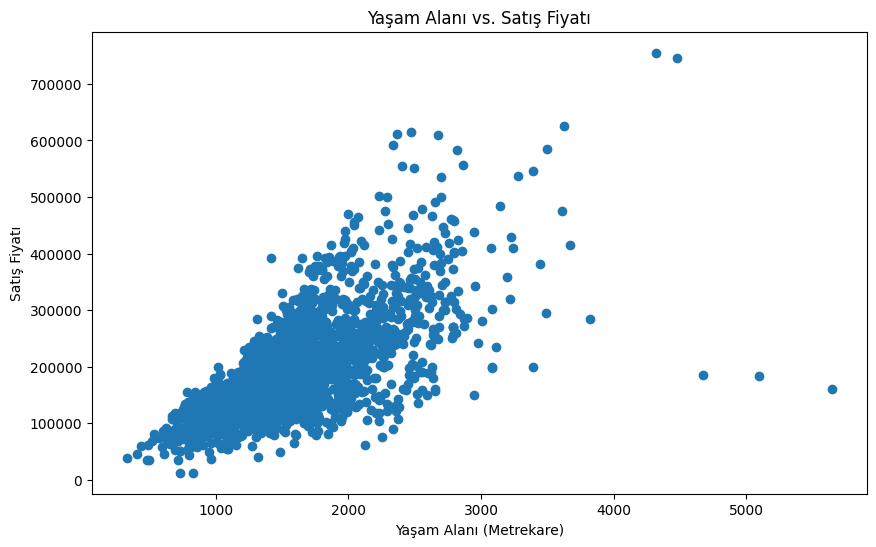

In [3]:
import matplotlib.pyplot as plt

# Saçılım grafiği oluştur
plt.figure(figsize=(10, 6))
plt.scatter(df["Gr Liv Area"], df["SalePrice"])
plt.title("Yaşam Alanı vs. Satış Fiyatı")
plt.xlabel("Yaşam Alanı (Metrekare)")
plt.ylabel("Satış Fiyatı")
plt.show()

## Correlation matrix
## Visualizing the correlation matrix

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\995047559.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


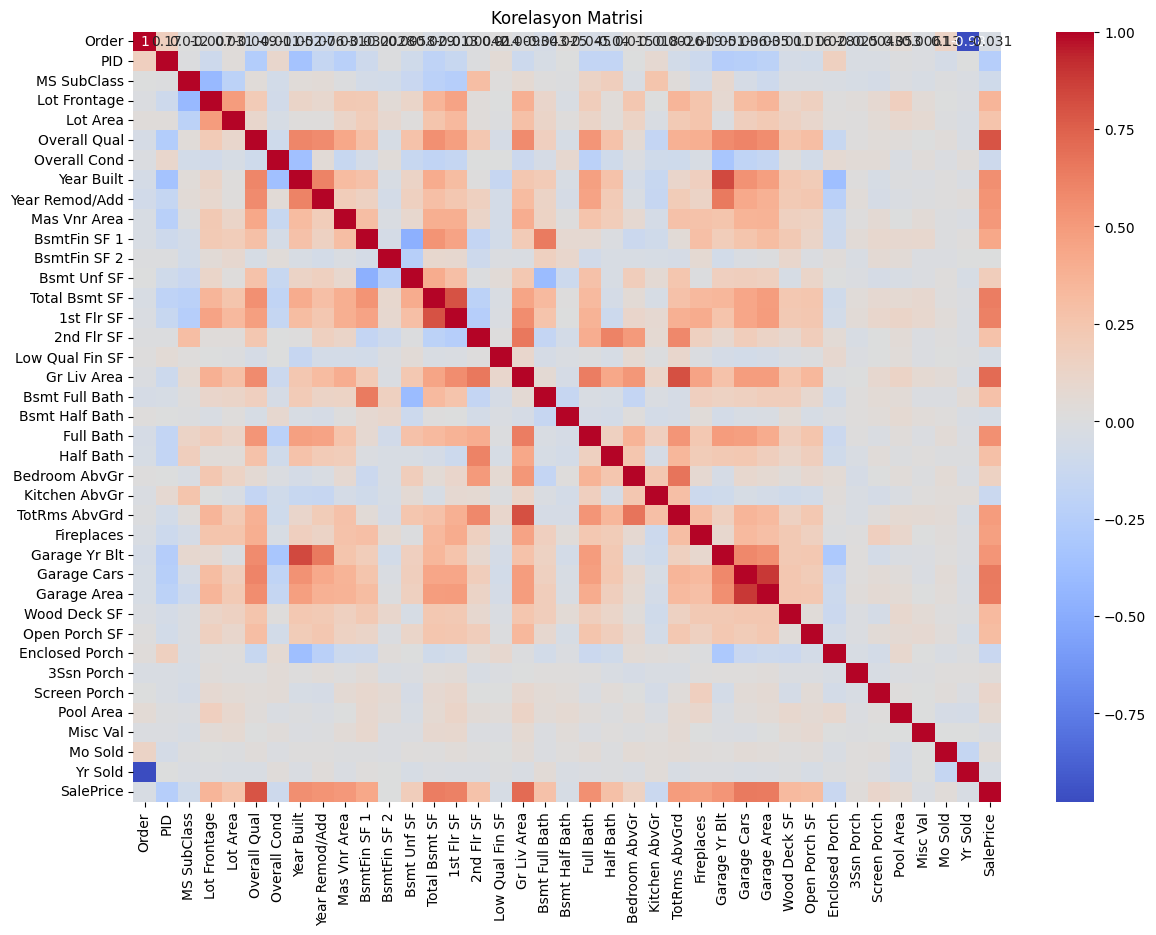

In [4]:
import seaborn as sns
import altair as alt

# Korelasyon matrisi oluştur
corr_matrix = df.corr()

# Altair ile ısı haritası oluştur
base = (
    alt.Chart(corr_matrix.reset_index().melt("index"))
    .encode(
        x="index",
        y="variable",
        color=alt.Color("value", scale=alt.Scale(range="diverging")),
        tooltip=["index", "variable", "value"],
    )
    .properties(title="Korelasyon Matrisi")
)

heatmap = base.mark_rect()

# Labels for the heatmap.
text = base.mark_text().encode(color=alt.value("black"), text="value:Q")

chart = heatmap + text
chart.save("correlation_matrix_heatmap.json")

# Seaborn ile ısı haritası oluştur
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()

## Finding the most correlated features with SalePrice

In [5]:
# SalePrice ile en yüksek korelasyona sahip özellikleri bul
price_correlations = corr_matrix["SalePrice"].sort_values(ascending=False)
print("SalePrice ile en yüksek korelasyona sahip özellikler:")
print(price_correlations.head(10))

# Önemli özellikleri seç (örneğin korelasyonu 0.5'ten büyük olanlar)
important_features = price_correlations[abs(price_correlations) > 0.5].index.tolist()
important_features.remove("SalePrice")  # Hedef değişkeni çıkar

SalePrice ile en yüksek korelasyona sahip özellikler:
SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Name: SalePrice, dtype: float64


##Finding the high correlated features with each other

In [6]:
# Yüksek korelasyonlu özellik çiftlerini bul
high_corr_features = np.where(np.abs(corr_matrix) > 0.8)
high_corr_features = [
    (corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
    for x, y in zip(*high_corr_features)
    if x != y and x < y
]

print("\nYüksek korelasyonlu özellik çiftleri:")
for feat1, feat2, corr in high_corr_features:
    print(f"{feat1} - {feat2}: {corr:.2f}")


Yüksek korelasyonlu özellik çiftleri:
Order - Yr Sold: -0.98
Year Built - Garage Yr Blt: 0.83
Total Bsmt SF - 1st Flr SF: 0.80
Gr Liv Area - TotRms AbvGrd: 0.81
Garage Cars - Garage Area: 0.89


## Basic
## Splitting the dataset into training and testing sets
## Encoding the categorical features

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# `df` DataFrame'inin bir kopyasını oluştur
df_copy = df.copy()

# Belirtilen sütunları veri setinden kaldır
df_dropped = df_copy.drop(
    ["Alley", "Pool QC", "Fence", "Misc Feature", "Fireplace Qu"], axis=1
)

# `Lot Frontage` sütunundaki eksik değerleri ortalama ile doldur
df_filled = df_dropped.fillna(df_dropped.mean())

# Kategorik sütunları one-hot encoding kullanarak sayısal değerlere dönüştür
categorical_cols = df_filled.select_dtypes(include=["object"]).columns
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(df_filled[categorical_cols]))
encoded_cols.index = df_filled.index
df_encoded = df_filled.drop(categorical_cols, axis=1)
df_encoded = pd.concat([df_encoded, encoded_cols], axis=1)

# `SalePrice` sütununu hedef değişken olarak ayır
y = df_encoded["SalePrice"]
X = df_encoded.drop("SalePrice", axis=1)

# Özellik matrisini ve hedef değişkeni eğitim ve test kümelerine ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Sonuçları yazdır
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\3250746712.py:13: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_filled = df_dropped.fillna(df_dropped.mean())


X_train shape: (2344, 297)
X_test shape: (586, 297)
y_train shape: (2344,)
y_test shape: (586,)


## Linear Regression
## Training the model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Lineer Regresyon modeli oluştur
model = LinearRegression()

# Sütun adlarını string türüne dönüştür
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# X_train ve X_test veri setlerindeki tüm eksik değerleri ilgili sütunların ortalaması ile doldur
for col in X_train.columns:
    if X_train[col].isnull().any():
        mean_val = X_train[col].mean()
        X_train[col] = X_train[col].fillna(mean_val)
        X_test[col] = X_test[col].fillna(
            mean_val
        )  # Test setini de aynı ortalama ile doldur

# Modeli eğitim verileriyle eğit
model.fit(X_train, y_train)

# Test verileri üzerinde tahminler yap
y_pred = model.predict(X_test)

# Ortalama karesel hata (MSE) ve R-kare skorunu hesapla
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdır
print(f"Ortalama Karesel Hata (MSE): {mse}")
print(f"R-kare Skoru: {r2}")

Ortalama Karesel Hata (MSE): 837911830.2255965
R-kare Skoru: 0.8954902624285619


## Cross Validation
## Cross validating the model
## Calculating the cross validation scores

In [12]:
from sklearn.model_selection import cross_val_score

# Tüm sütun adlarını string türüne dönüştür
X.columns = X.columns.astype(str)

# 5-fold çapraz doğrulama ile modelin MSE skorlarını hesapla
cv_scores = -cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")

# Her bir fold için MSE skorunu yazdır
for i, score in enumerate(cv_scores):
    print(f"{i+1}. Fold MSE: {score}")

# Ortalama MSE skorunu yazdır
print(f"Ortalama MSE: {cv_scores.mean()}")

1. Fold MSE: 771717828.857996
2. Fold MSE: 515674470.7001293
3. Fold MSE: 1185590816.4696186
4. Fold MSE: 1573021641.7442915
5. Fold MSE: 513543331.4772039
Ortalama MSE: 911909617.849848


## Feature Engineering
## Feature engineering the dataset
## Creating new features
## Filling the missing values


In [10]:
import numpy as np

# Yeni veri çerçevesini oluştur
df_featured = df.copy()

# İlk eksik değerleri doldur
categorical_fillna = {
    'Alley': 'None',
    'Pool QC': 'None',
    'Fence': 'None',
    'Misc Feature': 'None',
    'Fireplace Qu': 'No_Fireplace',
    'Garage Type': 'No_Garage',
    'Garage Finish': 'No_Garage',
    'Garage Qual': 'No_Garage',
    'Garage Cond': 'No_Garage',
    'Bsmt Qual': 'No_Basement',
    'Bsmt Cond': 'No_Basement',
    'Bsmt Exposure': 'No_Basement',
    'BsmtFin Type 1': 'No_Basement',
    'BsmtFin Type 2': 'No_Basement',
    'Mas Vnr Type': 'None',
    'Electrical': 'SBrkr'
}

df_featured = df_featured.fillna(categorical_fillna)

# Sayısal değişkenler için eksik değerleri doldur
df_featured['Garage Yr Blt'] = df_featured['Garage Yr Blt'].fillna(df_featured['Year Built'])
df_featured['Garage Cars'] = df_featured['Garage Cars'].fillna(0)
df_featured['Garage Area'] = df_featured['Garage Area'].fillna(0)
df_featured['BsmtFin SF 1'] = df_featured['BsmtFin SF 1'].fillna(0)
df_featured['BsmtFin SF 2'] = df_featured['BsmtFin SF 2'].fillna(0)
df_featured['Bsmt Unf SF'] = df_featured['Bsmt Unf SF'].fillna(0)
df_featured['Total Bsmt SF'] = df_featured['Total Bsmt SF'].fillna(0)
df_featured['Bsmt Full Bath'] = df_featured['Bsmt Full Bath'].fillna(0)
df_featured['Bsmt Half Bath'] = df_featured['Bsmt Half Bath'].fillna(0)
df_featured['Mas Vnr Area'] = df_featured['Mas Vnr Area'].fillna(0)

# Lot Frontage için mahalle bazında medyan değerler ile doldur
df_featured['Lot Frontage'] = df_featured.groupby('Neighborhood')['Lot Frontage'].transform(
    lambda x: x.fillna(x.median())
)
# Eğer hala eksik değer varsa genel medyan ile doldur
df_featured['Lot Frontage'] = df_featured['Lot Frontage'].fillna(df_featured['Lot Frontage'].median())


# Her adımdan sonra eksik değerleri kontrol et ve raporla
def check_missing(df, step=""):
    """Eksik değerleri kontrol et ve raporla"""
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    print(f"\n=== Eksik Değer Kontrolü ({step}) ===")
    if len(missing) > 0:
        print("Eksik değerler:")
        print(missing)
    else:
        print("Eksik değer yok!")
    return missing


# Yeni özellikleri ekle ve her adımda kontrol et
# 1. Toplam alan özelliği
df_featured["TotalSF"] = (
    df_featured["Total Bsmt SF"].fillna(0)
    + df_featured["1st Flr SF"]
    + df_featured["2nd Flr SF"]
)
check_missing(df_featured, "TotalSF eklendikten sonra")

# 2. Son tadilattan bu yana geçen süre
df_featured["AgeSinceRemod"] = df_featured["Year Remod/Add"] - df_featured["Year Built"]
check_missing(df_featured, "AgeSinceRemod eklendikten sonra")

# 3. Garaj ile ev arasındaki yaş farkı
df_featured["GarageAgeDiff"] = (
    df_featured["Garage Yr Blt"].fillna(df_featured["Year Built"])
    - df_featured["Year Built"]
)
check_missing(df_featured, "GarageAgeDiff eklendikten sonra")

# 4. LotArea özelliğinin logaritması
df_featured["LotAreaLog"] = np.log(df_featured["Lot Area"])
check_missing(df_featured, "LotAreaLog eklendikten sonra")

# 5. OverallQual özelliğini kategorik değişkene dönüştür
df_featured["OverallQualCat"] = pd.cut(
    df_featured["Overall Qual"],
    bins=[0, 3, 6, 10],
    labels=["Low", "Medium", "High"],
    include_lowest=True,
)
check_missing(df_featured, "OverallQualCat eklendikten sonra")

# 6. Toplam banyo sayısı
df_featured["TotalBaths"] = (
    df_featured["Full Bath"]
    + df_featured["Half Bath"] * 0.5
    + df_featured["Bsmt Full Bath"].fillna(0)
    + df_featured["Bsmt Half Bath"].fillna(0) * 0.5
)
check_missing(df_featured, "TotalBaths eklendikten sonra")

# 7. Ev yaşı ve yeni ev göstergesi
df_featured["HouseAge"] = df_featured["Yr Sold"] - df_featured["Year Built"]
df_featured["IsNew"] = (df_featured["HouseAge"] <= 2).astype(int)
check_missing(df_featured, "HouseAge ve IsNew eklendikten sonra")

# 8. Toplam veranda alanı
df_featured["TotalPorchSF"] = (
    df_featured["Open Porch SF"]
    + df_featured["Enclosed Porch"]
    + df_featured["3Ssn Porch"]
    + df_featured["Screen Porch"]
)
check_missing(df_featured, "TotalPorchSF eklendikten sonra")

# 9. Metrekare başına fiyat
df_featured["PriceSF"] = df_featured["SalePrice"] / df_featured["TotalSF"].replace(
    0, np.nan
)
median_price_sf = df_featured["PriceSF"].median()
df_featured["PriceSF"] = df_featured["PriceSF"].fillna(median_price_sf)
check_missing(df_featured, "PriceSF eklendikten sonra")

# 10. Kalite ve büyüklük etkileşimi
df_featured["QualitySize"] = df_featured["Overall Qual"] * df_featured["Gr Liv Area"]
check_missing(df_featured, "QualitySize eklendikten sonra")

# 11. Yaş ve kalite etkileşimi
df_featured["AgeQuality"] = df_featured["Overall Qual"] * (
    2010 - df_featured["Year Built"]
)
check_missing(df_featured, "AgeQuality eklendikten sonra")

# 12. Toplam banyo ve yatak odası alanı
df_featured["TotalBathBed"] = df_featured["TotalBaths"] * df_featured["Bedroom AbvGr"]
check_missing(df_featured, "TotalBathBed eklendikten sonra")

# Son kontrol
final_missing = check_missing(df_featured, "Final kontrol")
print(f"\nVeri seti boyutu: {df_featured.shape}")


"""Target Leakage Problemi:
PriceSF, SalePrice kullanılarak oluşturulmuş
Model dolaylı yoldan test setindeki SalePrice bilgisine erişmiş oluyor
Bu durum overfitting'e ve yanıltıcı model performansına yol açar"""

# 1. PriceSF'i kaldır
df_featured = df_featured.drop('PriceSF', axis=1)

# 2. Alternatif olarak, benzer bir insight için:
# Medyan fiyatları kullanarak neighborhood bazında price/sf hesapla
neighborhood_price_sf = df_featured.groupby('Neighborhood').agg({
    'SalePrice': 'median',
    'TotalSF': 'median'
}).eval('NeighborhoodPriceSF = SalePrice / TotalSF')

# Bu değeri ana veri setine ekle
df_featured = df_featured.merge(
    neighborhood_price_sf[['NeighborhoodPriceSF']], 
    left_on='Neighborhood', 
    right_index=True
)

# Düşük fiyatlı evler için özel özellikler
df_featured["Age_Quality_Interaction"] = df_featured["HouseAge"] * df_featured["Overall Qual"]
df_featured["Location_Quality"] = df_featured["NeighborhoodPriceSF"] * df_featured["Overall Qual"]
df_featured["Maintenance_Score"] = (df_featured["Overall Cond"] + df_featured["Overall Qual"]) / 2

c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



=== Eksik Değer Kontrolü (TotalSF eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (AgeSinceRemod eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (GarageAgeDiff eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (LotAreaLog eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (OverallQualCat eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (TotalBaths eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (HouseAge ve IsNew eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (TotalPorchSF eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (PriceSF eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (QualitySize eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (AgeQuality eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (TotalBathBed eklendikten sonra) ===
Eksik değer yok!

=== Eksik Değer Kontrolü (Final kontrol) ===
Ek

## Scaling the dataset
## Calculating the VIF(Variance Inflation Factor)
## Creating the interaction term


In [11]:
from sklearn.discriminant_analysis import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Önce ölçeklendirme yap

scaler = StandardScaler()

numeric_features = ["Overall Qual", "Gr Liv Area"]

df_scaled = df_featured.copy()

df_scaled[numeric_features] = scaler.fit_transform(df_featured[numeric_features])


# 2. Interaction term'i oluştur

df_scaled["Qual_Size_Interaction"] = (

    df_scaled["Overall Qual"] * df_scaled["Gr Liv Area"]
)


# 3. Korelasyonu kontrol et

correlation_matrix = df_scaled[

    ["Overall Qual", "Gr Liv Area", "Qual_Size_Interaction"]
].corr()

print("\nKorelasyon Matrisi:")

print(correlation_matrix)


# 4. VIF (Variance Inflation Factor) kontrolü



def calculate_vif(df, features):

    vif_data = pd.DataFrame()

    vif_data["Feature"] = features

    vif_data["VIF"] = [

        variance_inflation_factor(df[features].values, i)

        for i in range(df[features].shape[1])
    ]
    return vif_data



vif_data = calculate_vif(

    df_scaled, ["Overall Qual", "Gr Liv Area", "Qual_Size_Interaction"]
)

print("\nVIF Değerleri:")

print(vif_data)


Korelasyon Matrisi:
                       Overall Qual  Gr Liv Area  Qual_Size_Interaction
Overall Qual               1.000000     0.570556               0.187206
Gr Liv Area                0.570556     1.000000               0.318240
Qual_Size_Interaction      0.187206     0.318240               1.000000

VIF Değerleri:
                 Feature       VIF
0           Overall Qual  1.482719
1            Gr Liv Area  1.573760
2  Qual_Size_Interaction  1.093940


### VIF < 5 ise sorun yok
### VIF < 10 ise kabul edilebilir
### VIF > 10 ise multicollinearity problemi var

VIF Sonuçları:
- Overall Qual: 1.48       ✓ Çok iyi
- Gr Liv Area: 1.57        ✓ Çok iyi
- Interaction: 1.09        ✓ Mükemmel

In [12]:
"""import numpy as np

# Yeni veri çerçevesini oluştur
df_featured = df.copy()

# Toplam alan özelliğini oluştur
df_featured["TotalSF"] = (
    df_featured["Total Bsmt SF"] + df_featured["1st Flr SF"] + df_featured["2nd Flr SF"]
)

# Son tadilattan bu yana geçen süreyi hesapla
df_featured["AgeSinceRemod"] = df_featured["Year Remod/Add"] - df_featured["Year Built"]

# Garaj ile ev arasındaki yaş farkını hesapla
df_featured["GarageAgeDiff"] = df_featured["Garage Yr Blt"] - df_featured["Year Built"]

# LotArea özelliğinin logaritmasını al
df_featured["LotAreaLog"] = np.log(df_featured["Lot Area"])

# OverallQual özelliğini kategorik değişkene dönüştür
df_featured["OverallQualCat"] = pd.cut(
    df_featured["Overall Qual"], bins=[1, 3, 6, 10], labels=["Low", "Medium", "High"]
)

# İlk 5 satırı ve tüm sütunları görüntüle
print(df_featured.head().to_markdown(index=False, numalign="left", stralign="left"))

# DataFrame'in sütun adlarını ve veri tiplerini görüntüle
print(df_featured.info())
# Yeni özellikler ekle
df_featured["TotalBaths"] = (
    df_featured["Full Bath"]
    + df_featured["Half Bath"] * 0.5
    + df_featured["Bsmt Full Bath"]
    + df_featured["Bsmt Half Bath"] * 0.5
)

df_featured["HouseAge"] = df_featured["Yr Sold"] - df_featured["Year Built"]
df_featured["IsNew"] = (df_featured["HouseAge"] <= 2).astype(int)

df_featured["TotalPorchSF"] = (
    df_featured["Open Porch SF"]
    + df_featured["Enclosed Porch"]
    + df_featured["3Ssn Porch"]
    + df_featured["Screen Porch"]
)

# Metrekare başına fiyat hesapla
df_featured["PriceSF"] = df_featured["SalePrice"] / df_featured["TotalSF"]

# Yeni özellikleri kontrol et
print("Yeni özellikler eklendi. İlk 5 satır:")
print(
    df_featured[["TotalBaths", "HouseAge", "IsNew", "TotalPorchSF", "PriceSF"]].head()
)
# Kalite ve büyüklük özelliklerini birleştir
df_featured["QualitySize"] = df_featured["Overall Qual"] * df_featured["Gr Liv Area"]

# Yaş ve kalite etkileşimi
df_featured["AgeQuality"] = df_featured["Overall Qual"] * (
    2010 - df_featured["Year Built"]
)

# Toplam banyo ve yatak odası alanı
df_featured["TotalBathBed"] = df_featured["TotalBaths"] * df_featured["Bedroom AbvGr"]

# Garaj ve ev yaşı arasındaki fark
df_featured["GarageHouseDiff"] = (
    df_featured["Garage Yr Blt"].fillna(df_featured["Year Built"])
    - df_featured["Year Built"])
# Lot Frontage için kalan eksik değerleri genel medyan ile doldur
lot_frontage_median = df_featured["Lot Frontage"].median()
df_featured["Lot Frontage"] = df_featured["Lot Frontage"].fillna(lot_frontage_median)

# Son kontrol
final_missing = df_featured.isnull().sum()
final_missing = final_missing[final_missing > 0]
print("\nTemizlik sonrası kalan eksik değerler:")
if len(final_missing) > 0:
    print(final_missing.to_markdown())
else:
    print("Tüm eksik değerler temizlendi!")

# Yüksek korelasyonlu özelliklerin korelasyon matrisini göster
high_corr_features = [
    "Overall Qual",
    "Year Built",
    "Year Remod/Add",
    "Mas Vnr Area",
    "Total Bsmt SF",
    "1st Flr SF",
    "Gr Liv Area",
    "Full Bath",
    "Garage Yr Blt",
    "Garage Cars",
    "Garage Area",
    "TotalSF",
    "TotalBaths",
    "HouseAge",
    "PriceSF",
    "QualitySize",
    "SalePrice",
]

plt.figure(figsize=(15, 10))
sns.heatmap(
    df_featured[high_corr_features].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
)
plt.title("Yüksek Korelasyonlu Özellikler Arasındaki İlişkiler")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()"""

'import numpy as np\n\n# Yeni veri çerçevesini oluştur\ndf_featured = df.copy()\n\n# Toplam alan özelliğini oluştur\ndf_featured["TotalSF"] = (\n    df_featured["Total Bsmt SF"] + df_featured["1st Flr SF"] + df_featured["2nd Flr SF"]\n)\n\n# Son tadilattan bu yana geçen süreyi hesapla\ndf_featured["AgeSinceRemod"] = df_featured["Year Remod/Add"] - df_featured["Year Built"]\n\n# Garaj ile ev arasındaki yaş farkını hesapla\ndf_featured["GarageAgeDiff"] = df_featured["Garage Yr Blt"] - df_featured["Year Built"]\n\n# LotArea özelliğinin logaritmasını al\ndf_featured["LotAreaLog"] = np.log(df_featured["Lot Area"])\n\n# OverallQual özelliğini kategorik değişkene dönüştür\ndf_featured["OverallQualCat"] = pd.cut(\n    df_featured["Overall Qual"], bins=[1, 3, 6, 10], labels=["Low", "Medium", "High"]\n)\n\n# İlk 5 satırı ve tüm sütunları görüntüle\nprint(df_featured.head().to_markdown(index=False, numalign="left", stralign="left"))\n\n# DataFrame\'in sütun adlarını ve veri tiplerini görüntüle\np

### Feature Engineering


=== DOLDURMA ÖNCESİ EKSİK DEĞER ANALİZİ ===

Overall Qual (Doldurma Öncesi):
Eksik değer sayısı: 0
Eksik değer yüzdesi: 0.00%

Betimsel istatistikler:
count    2930.000000
mean        6.094881
std         1.411026
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: Overall Qual, dtype: float64

Year Built (Doldurma Öncesi):
Eksik değer sayısı: 0
Eksik değer yüzdesi: 0.00%

Betimsel istatistikler:
count    2930.000000
mean     1971.356314
std        30.245361
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2001.000000
max      2010.000000
Name: Year Built, dtype: float64

Year Remod/Add (Doldurma Öncesi):
Eksik değer sayısı: 0
Eksik değer yüzdesi: 0.00%

Betimsel istatistikler:
count    2930.000000
mean     1984.266553
std        20.860286
min      1950.000000
25%      1965.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: Year Remod/Add, dtype: float64

Mas Vnr Area (Doldurma Ön

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


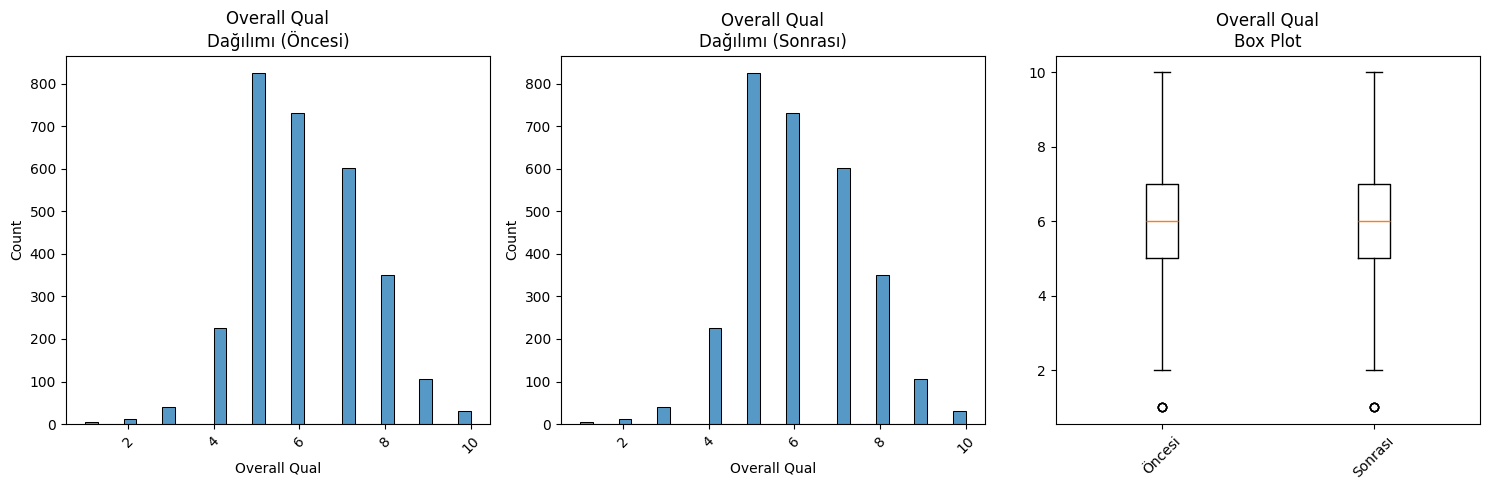

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


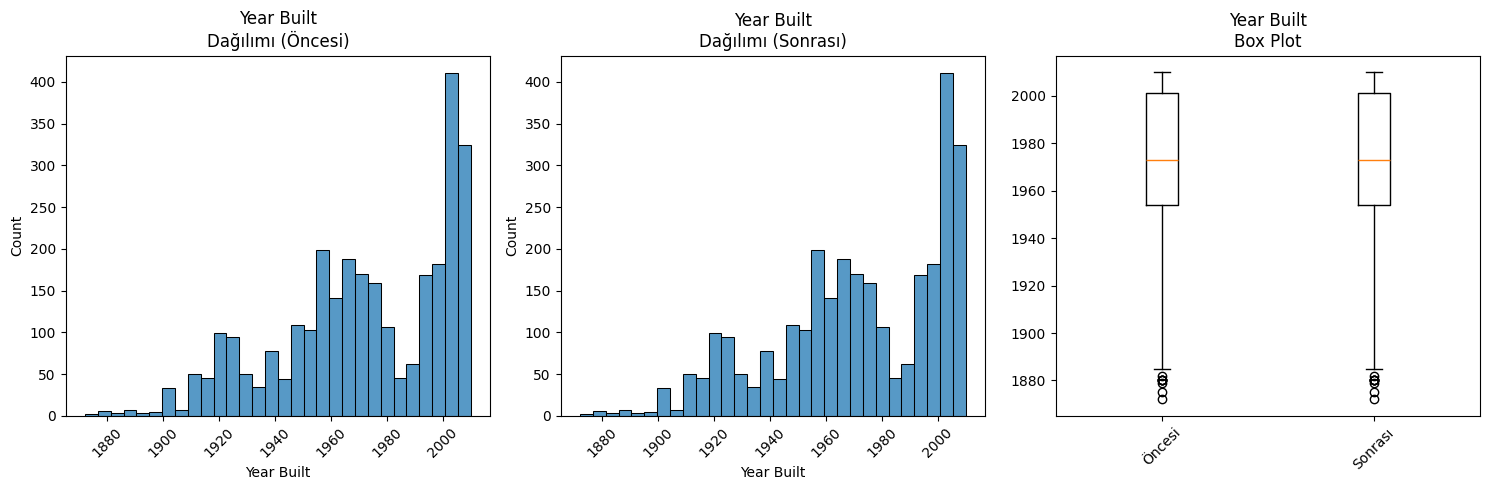

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


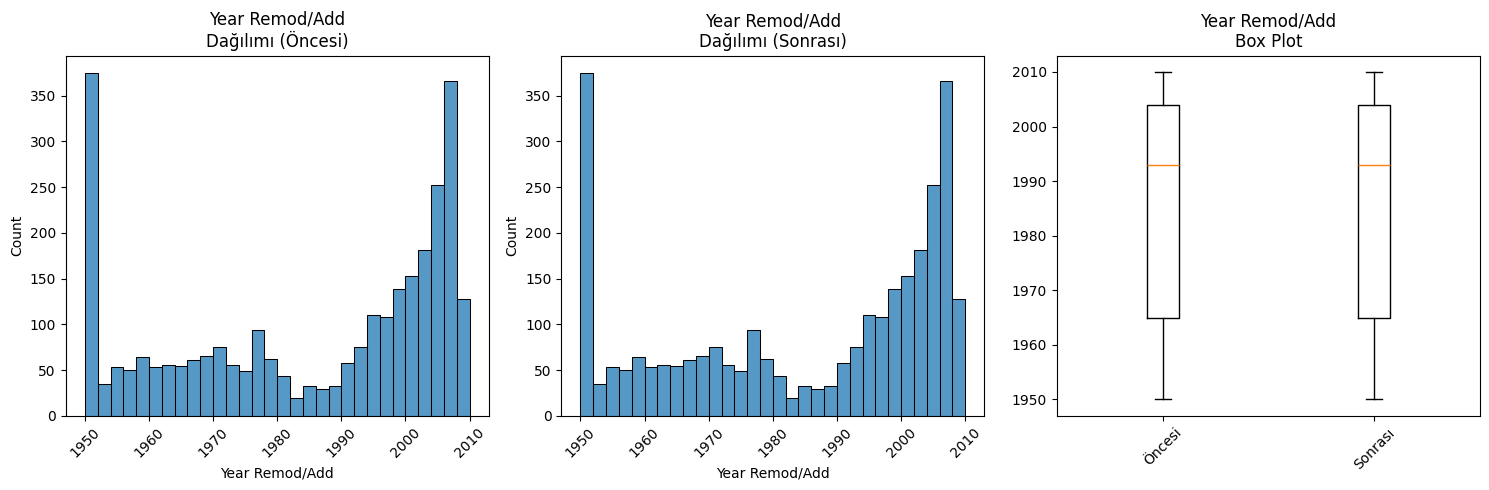

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


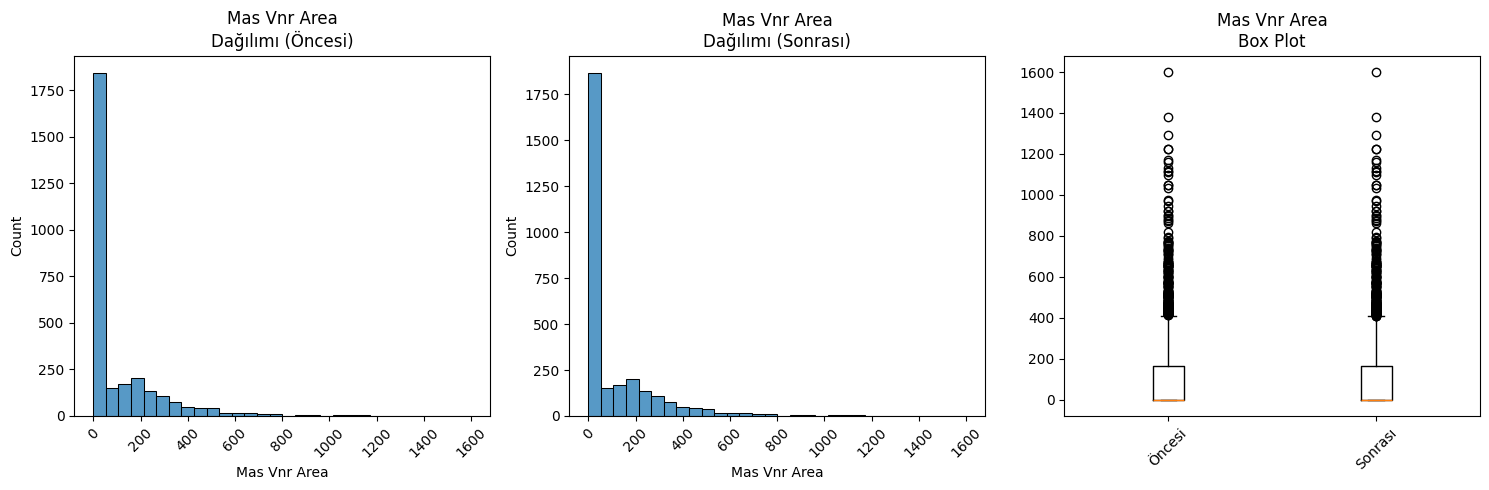

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


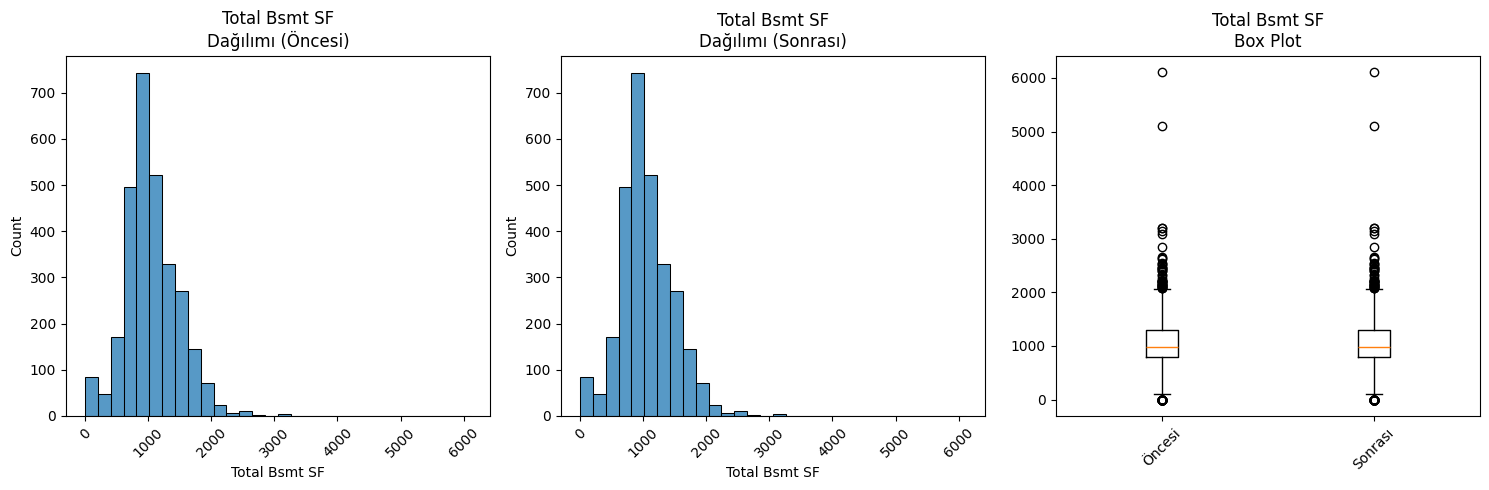

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


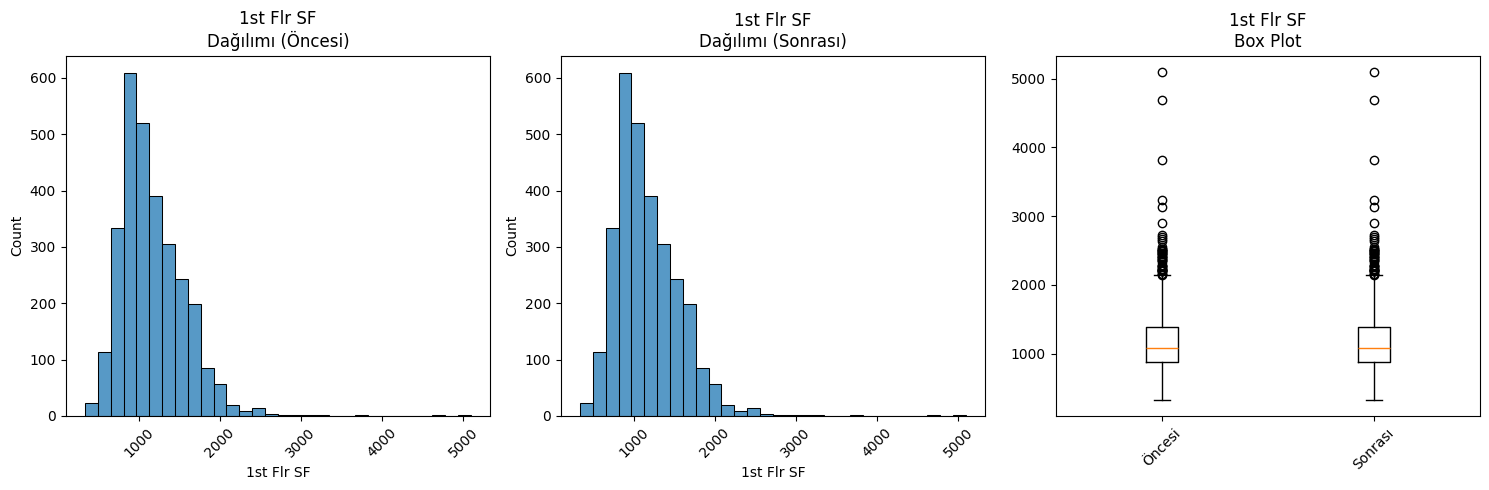

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


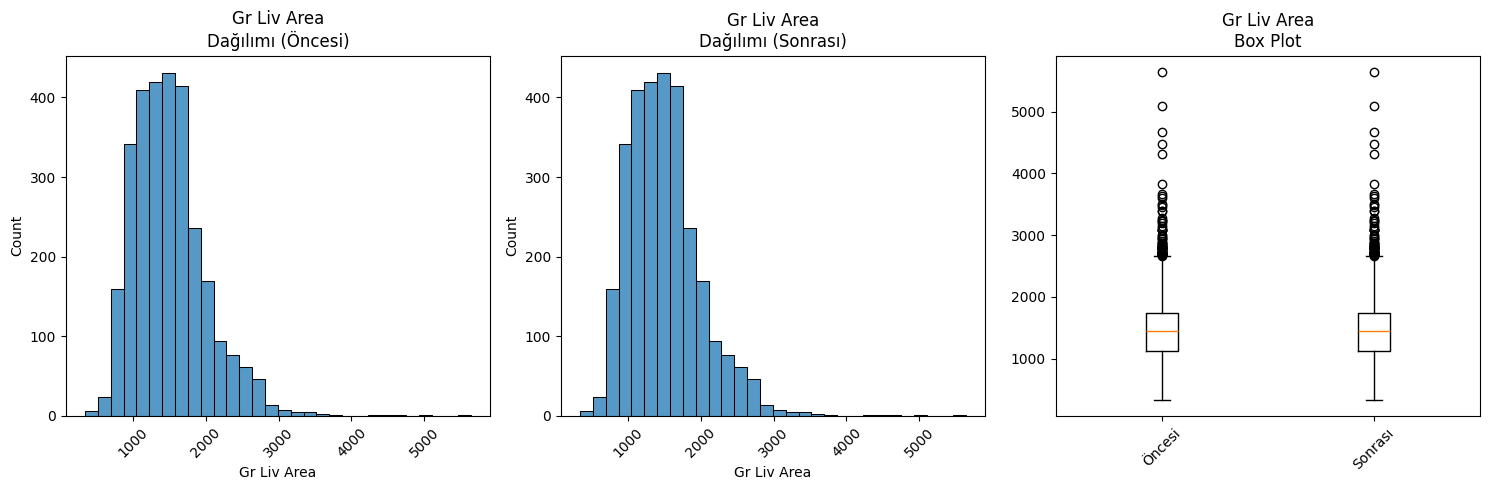

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


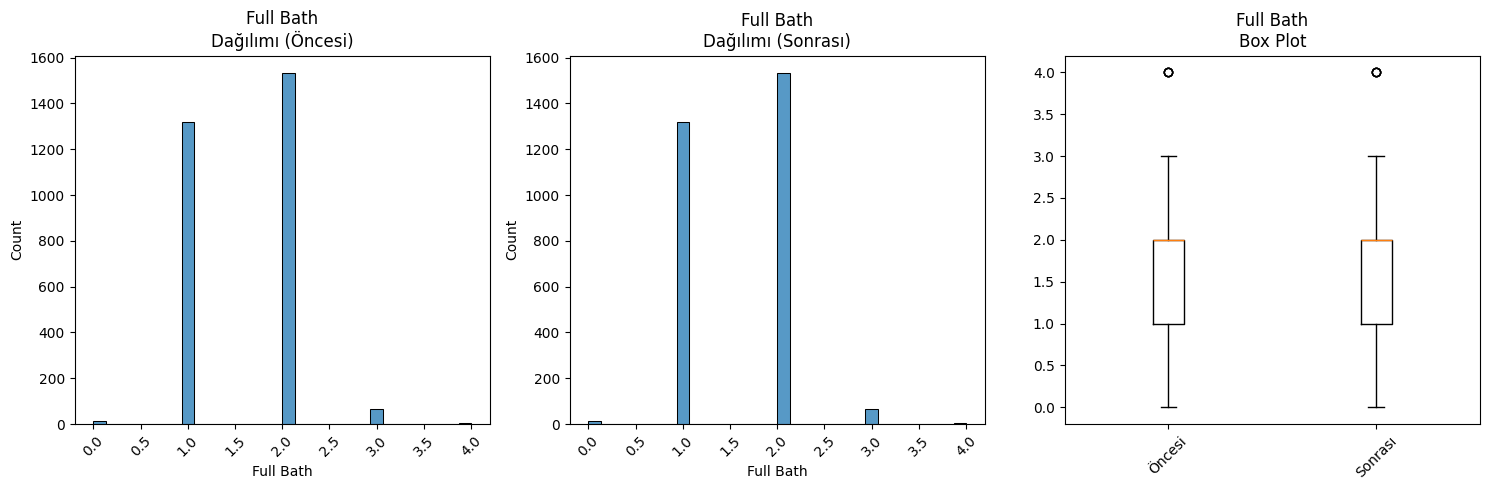

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


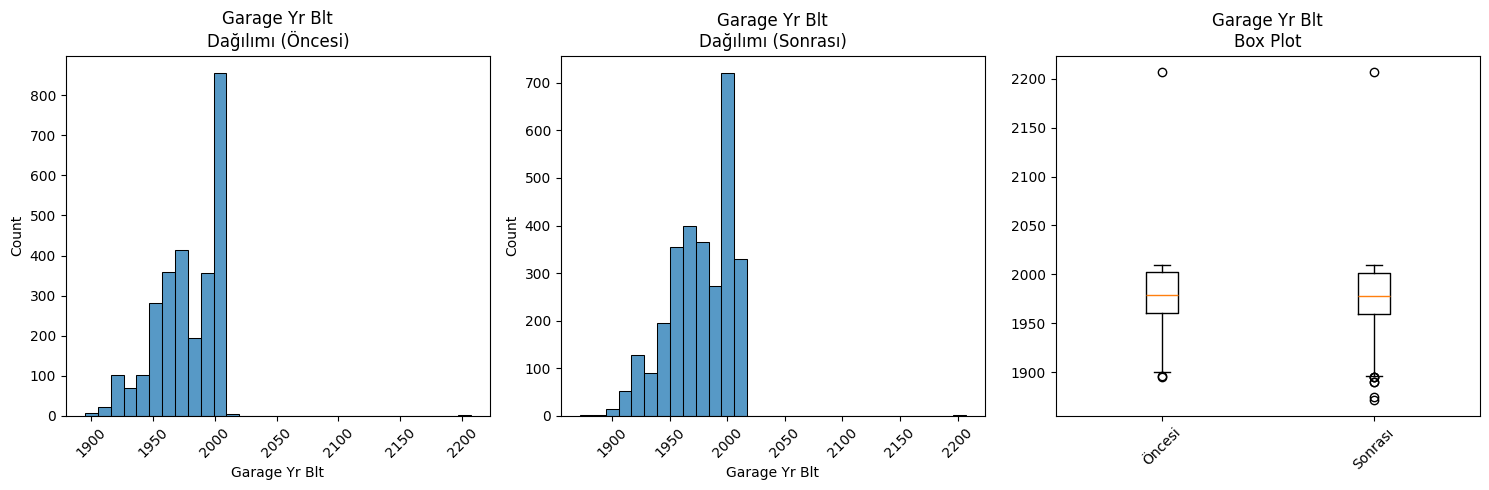

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


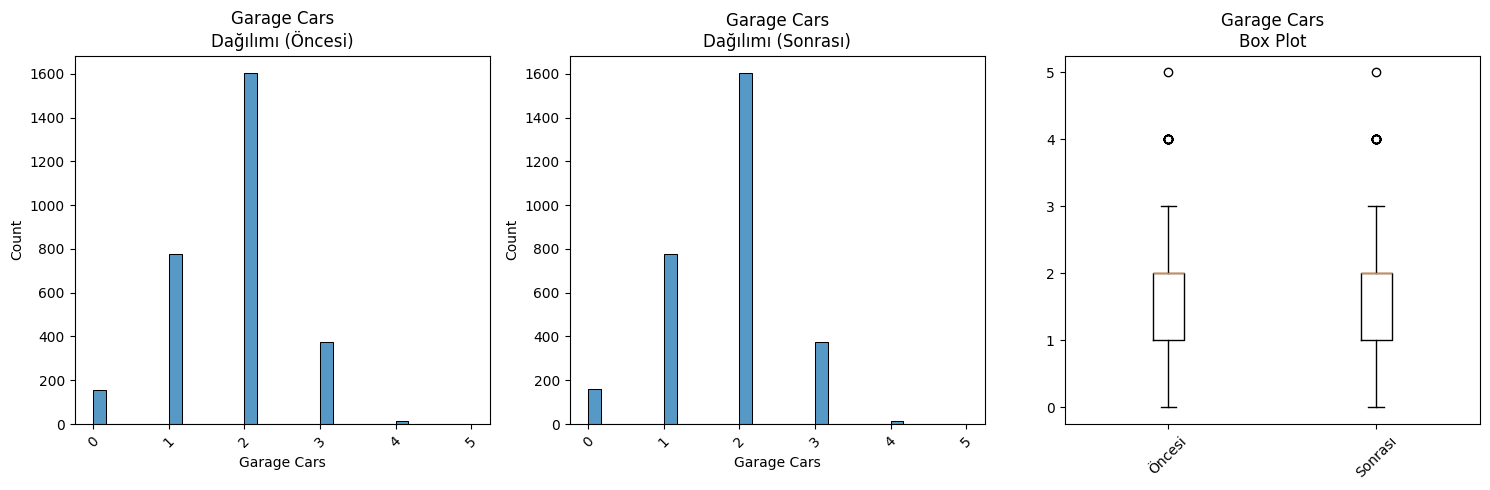

C:\Users\muham\AppData\Local\Temp\ipykernel_8712\1966232187.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


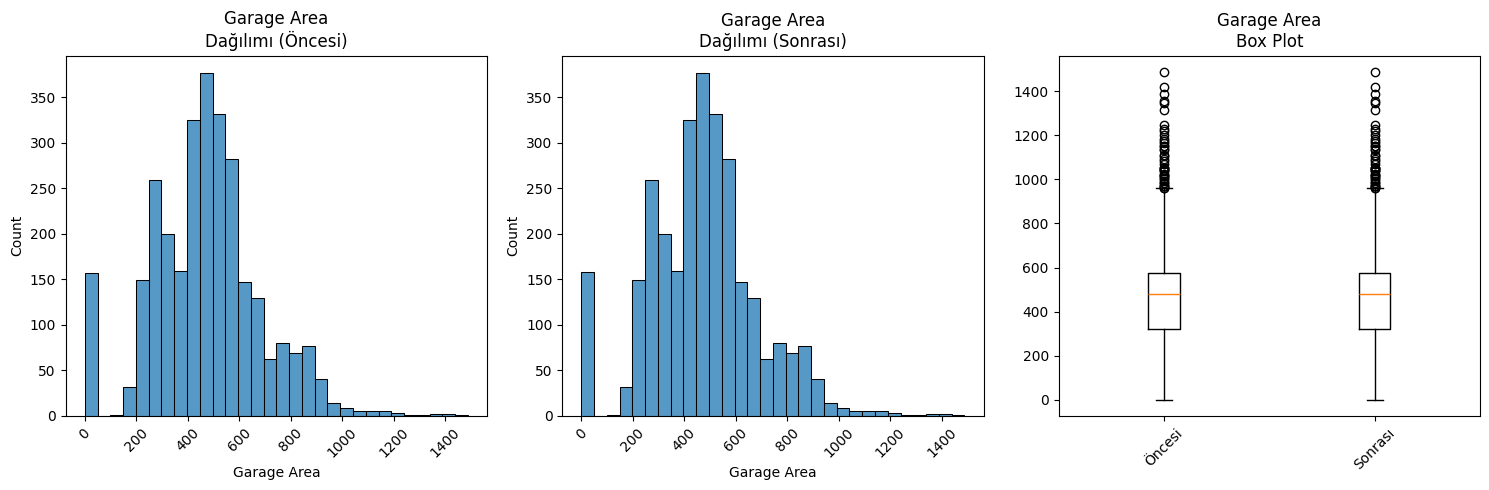

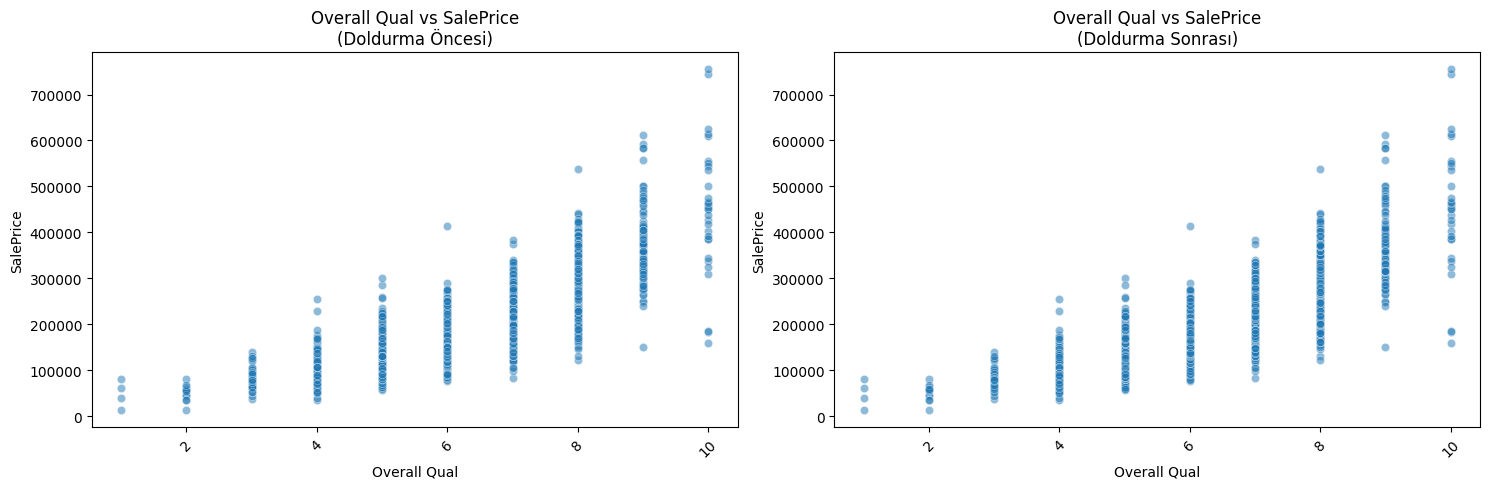

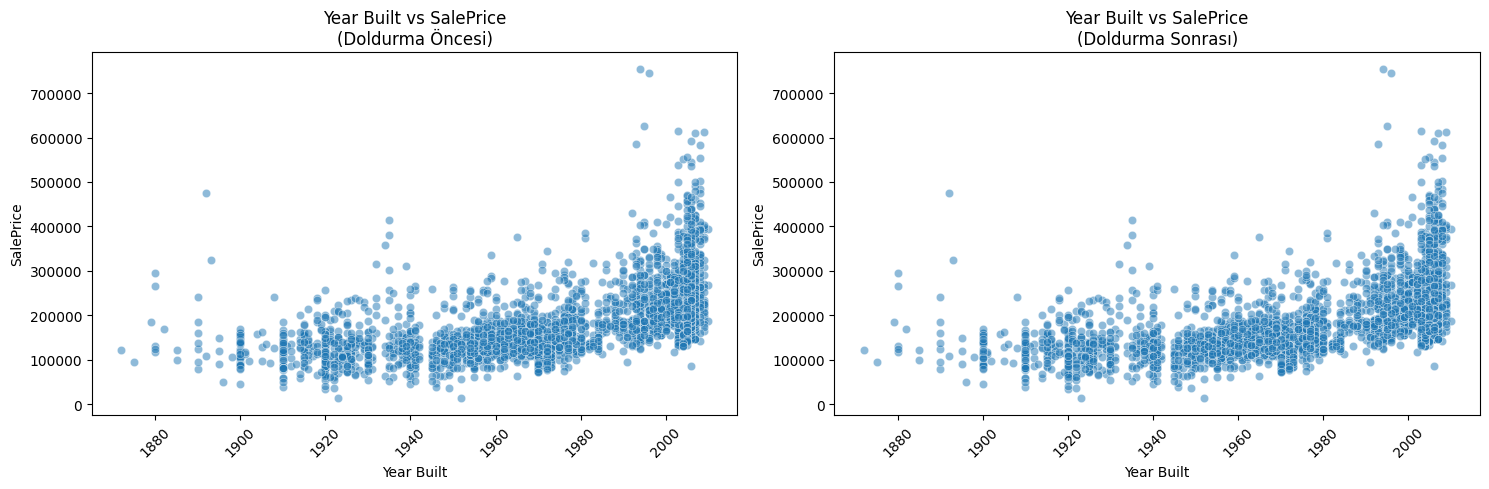

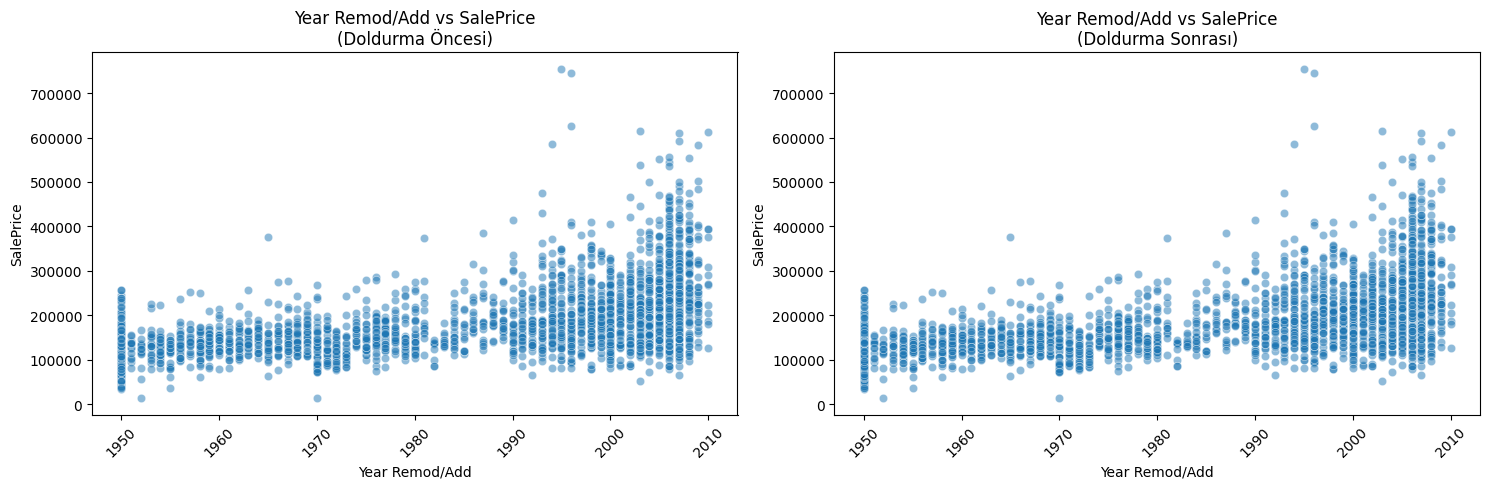

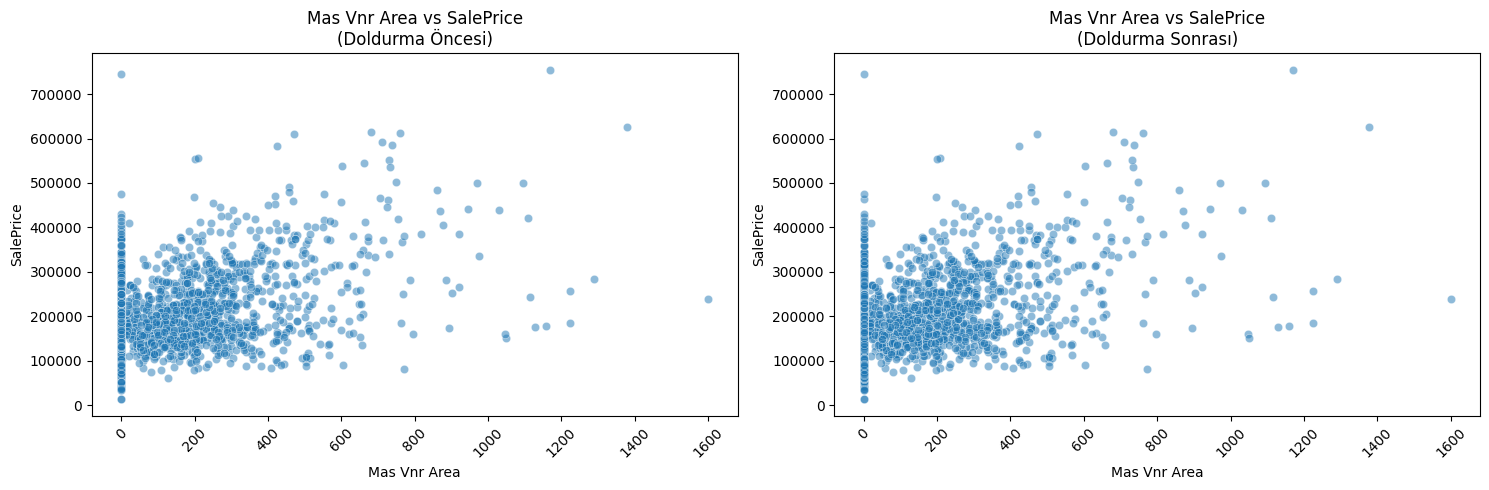

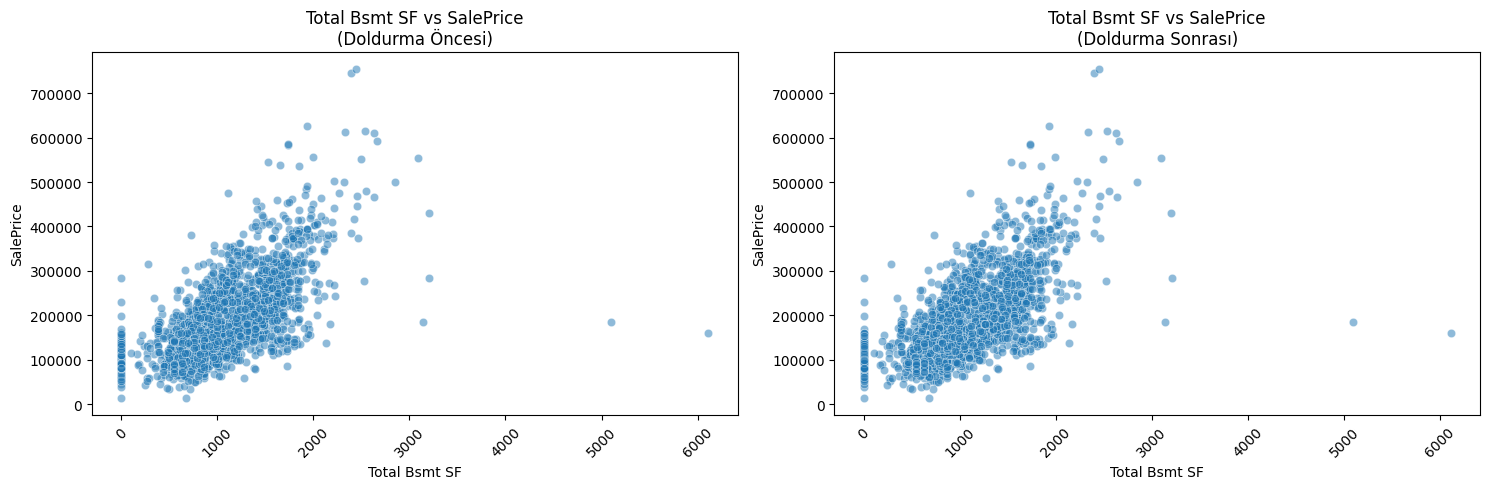

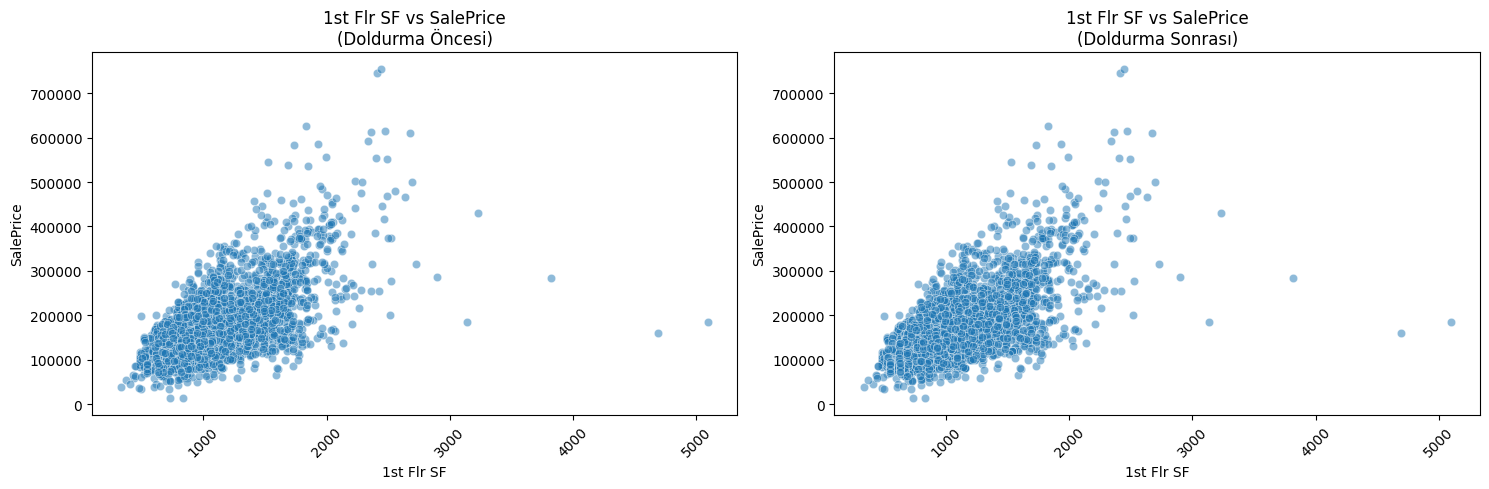

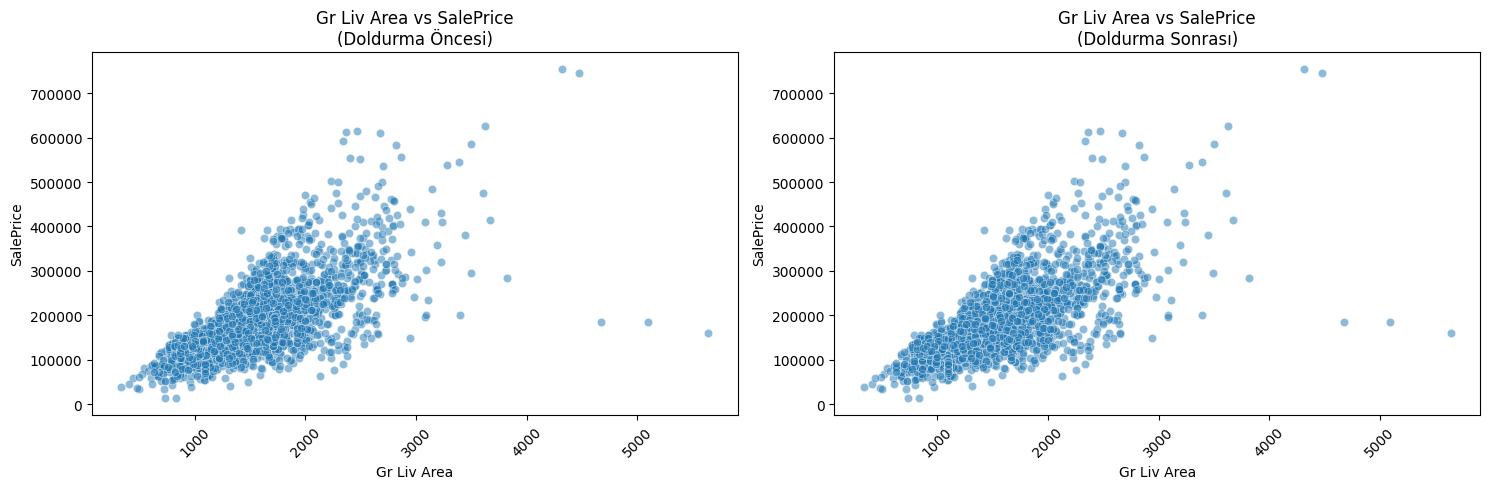

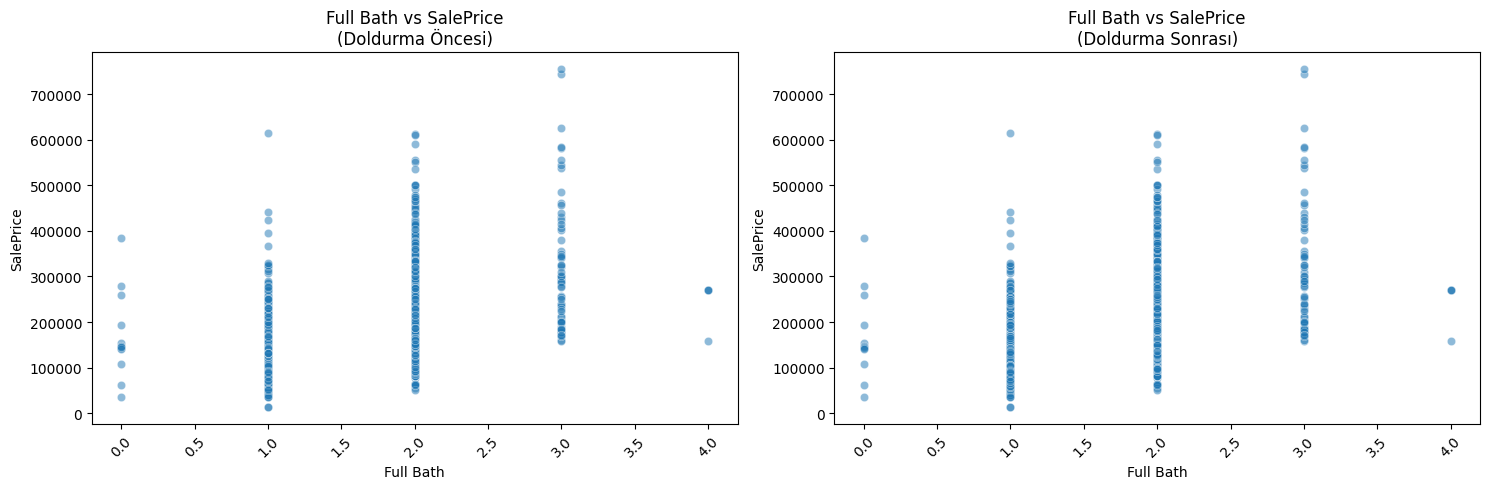

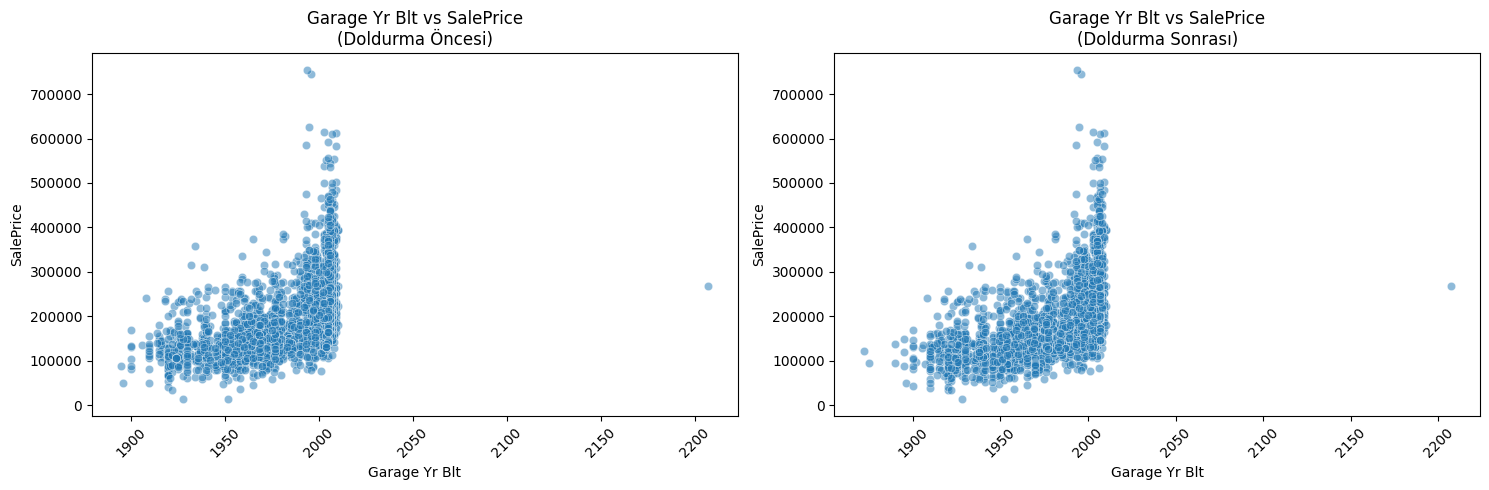

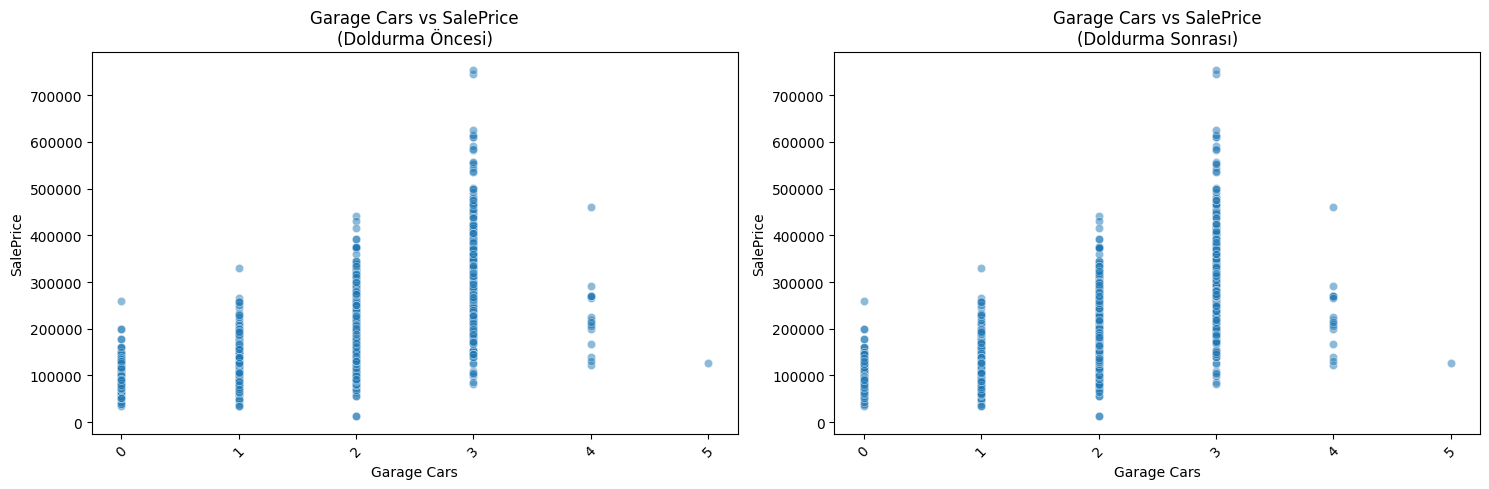

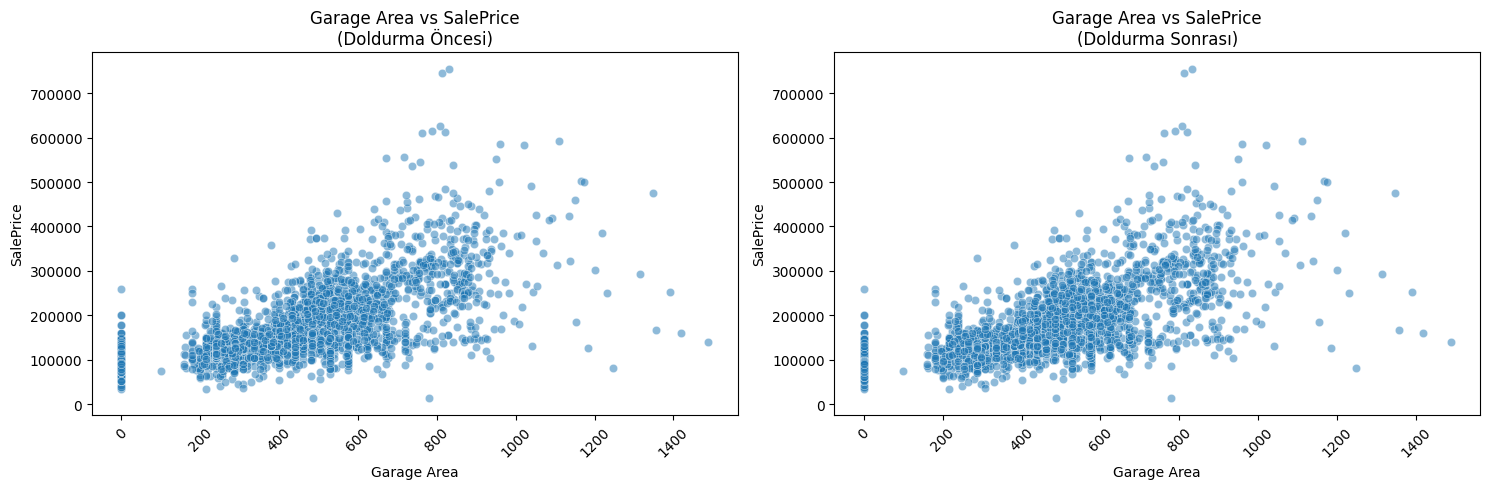


=== SalePrice ile En Yüksek Korelasyona Sahip Özellikler ===
SalePrice              1.000000
QualitySize            0.845441
Location_Quality       0.835581
Overall Qual           0.799262
TotalSF                0.793127
Gr Liv Area            0.706780
NeighborhoodPriceSF    0.698447
Garage Cars            0.647562
Garage Area            0.640138
TotalBaths             0.636175
Total Bsmt SF          0.632529
1st Flr SF             0.621676
Maintenance_Score      0.592908
Year Built             0.558426
Full Bath              0.545604
Name: SalePrice, dtype: float64


In [13]:
# Orijinal veri setinden kopya oluştur
df_original = df.copy()

# Yüksek korelasyonlu özelliklerimiz 
high_corr_features = [
    # Orijinal özellikler
    "Overall Qual",
    "Year Built",
    "Year Remod/Add",
    "Mas Vnr Area",
    "Total Bsmt SF",
    "1st Flr SF",
    "Gr Liv Area",
    "Full Bath",
    "Garage Yr Blt",
    "Garage Cars",
    "Garage Area",
 
]


def analyze_feature(df, feature_name, stage=""):
    """Özellik analizi yapan yardımcı fonksiyon"""
    missing_count = df[feature_name].isnull().sum()
    total_count = len(df[feature_name])
    missing_percentage = (missing_count / total_count) * 100

    print(f"\n{feature_name} ({stage}):")
    print(f"Eksik değer sayısı: {missing_count}")
    print(f"Eksik değer yüzdesi: {missing_percentage:.2f}%")
    if feature_name in df.columns:
        print("\nBetimsel istatistikler:")
        print(df[feature_name].describe())


# 1. Doldurma öncesi ve sonrası eksik değer analizi
print("=== DOLDURMA ÖNCESİ EKSİK DEĞER ANALİZİ ===")
for feature in high_corr_features:
    if feature in df_original.columns:  # Orijinal veri setinde var olan özellikler
        analyze_feature(df_original, feature, "Doldurma Öncesi")
    else:
        print(f"\n{feature}: Türetilmiş özellik")

print("\n=== DOLDURMA SONRASI EKSİK DEĞER ANALİZİ ===")
for feature in high_corr_features:
    if feature in df_featured.columns:  # df_featured'da var olan özellikler
        analyze_feature(df_featured, feature, "Doldurma Sonrası")

# 2. Doldurma öncesi ve sonrası dağılımların karşılaştırılması
for feature in high_corr_features:
    if feature in df_original.columns:  # Sadece orijinal özellikleri karşılaştır
        plt.figure(figsize=(15, 5))

        # Doldurma öncesi histogram
        plt.subplot(131)
        sns.histplot(df_original[feature].dropna(), bins=30)
        plt.title(f"{feature}\nDağılımı (Öncesi)")
        plt.xticks(rotation=45)

        # Doldurma sonrası histogram
        plt.subplot(132)
        sns.histplot(df_featured[feature], bins=30)
        plt.title(f"{feature}\nDağılımı (Sonrası)")
        plt.xticks(rotation=45)

        # Box plot karşılaştırması
        plt.subplot(133)
        plt.boxplot(
            [df_original[feature].dropna(), df_featured[feature]],
            labels=["Öncesi", "Sonrası"],
        )
        plt.title(f"{feature}\nBox Plot")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

# 3. SalePrice ile ilişki karşılaştırması
for feature in high_corr_features:
    if isinstance(df_featured[feature].dtype, pd.CategoricalDtype):
        # Kategorik değişkenler için box plot
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        sns.boxplot(data=df_original, x=feature, y="SalePrice")
        plt.title(f"{feature} vs SalePrice\n(Doldurma Öncesi)")
        plt.xticks(rotation=45)

        plt.subplot(122)
        sns.boxplot(data=df_featured, x=feature, y="SalePrice")
        plt.title(f"{feature} vs SalePrice\n(Doldurma Sonrası)")
        plt.xticks(rotation=45)

    else:
        # Sayısal değişkenler için scatter plot
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        sns.scatterplot(
            data=df_original.dropna(subset=[feature]),
            x=feature,
            y="SalePrice",
            alpha=0.5,
        )
        plt.title(f"{feature} vs SalePrice\n(Doldurma Öncesi)")
        plt.xticks(rotation=45)

        plt.subplot(122)
        sns.scatterplot(data=df_featured, x=feature, y="SalePrice", alpha=0.5)
        plt.title(f"{feature} vs SalePrice\n(Doldurma Sonrası)")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# 4. Korelasyon analizi
numeric_features = df_featured.select_dtypes(include=["int64", "float64"]).columns
correlation_matrix = (
    df_featured[numeric_features].corr()["SalePrice"].sort_values(ascending=False)
)
print("\n=== SalePrice ile En Yüksek Korelasyona Sahip Özellikler ===")
print(correlation_matrix.head(15))

### Models
### Linear Regression
### Ridge Regression
### Lasso Regression
### Random Forest

=== Model Performans Karşılaştırması ===

Linear Regression:
RMSE: $29,775.78
R2 Score: 0.8582
Cross-Val R2: 0.7981 (+/- 0.0718)

Ridge Regression:
RMSE: $29,808.56
R2 Score: 0.8579
Cross-Val R2: 0.7982 (+/- 0.0710)

Lasso Regression:
RMSE: $29,777.08
R2 Score: 0.8582
Cross-Val R2: 0.7981 (+/- 0.0718)

Random Forest:
RMSE: $26,832.59
R2 Score: 0.8849
Cross-Val R2: 0.8630 (+/- 0.0252)


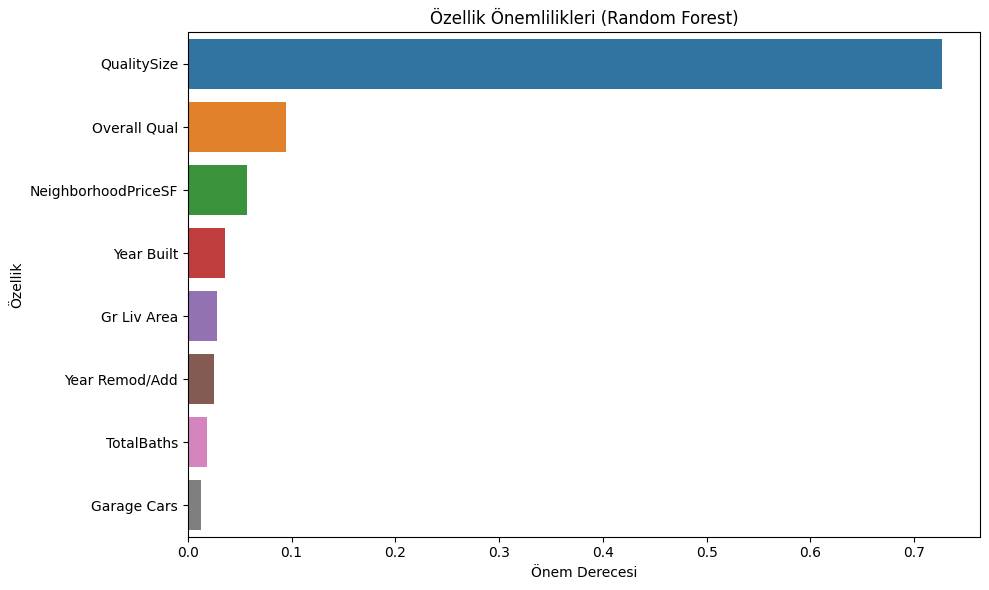

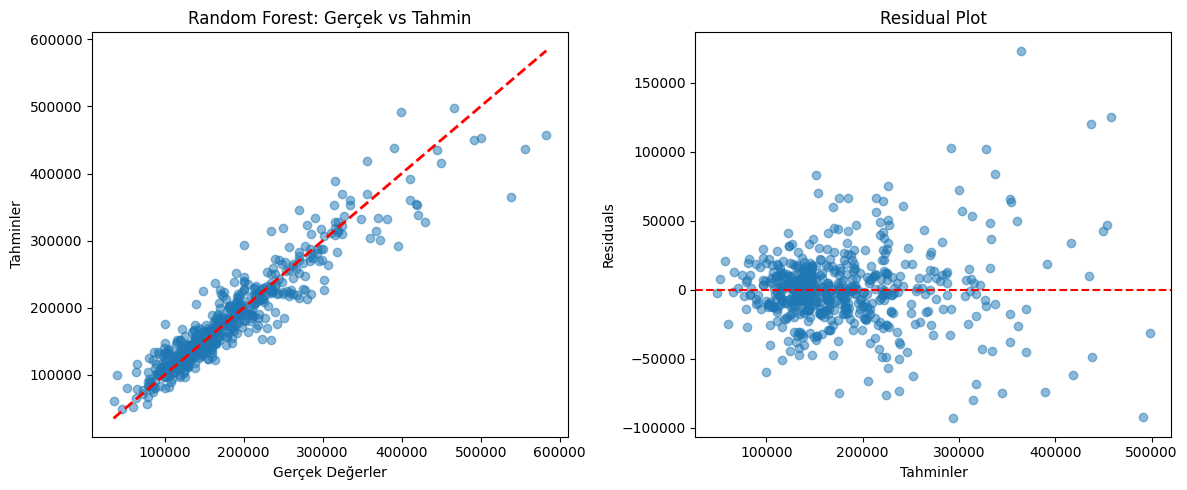

In [14]:

# Yüksek korelasyonlu özellikleri seçelim
features = [
    "QualitySize",  # En yüksek korelasyon (0.845)
    "Overall Qual",  # 0.799
    "Gr Liv Area",  # 0.707 (TotalSF yerine, çünkü daha temel bir özellik)
    "NeighborhoodPriceSF",  # 0.698447
    "Garage Cars",  # 0.648
    "TotalBaths",  # 0.636
    "Year Built",  # 0.558
    "Year Remod/Add",  # 0.533
]

# Not: TotalSF, Garage Area, Total Bsmt SF ve 1st Flr SF'yi çıkardık
# çünkü bunlar diğer değişkenlerle yüksek korelasyonlu

X = df_featured[features]
y = df_featured["SalePrice"]

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Özellikleri ölçeklendir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modeller
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,  # Arttırıldı
        max_depth=10,  # Derinlik sınırı eklendi
        min_samples_split=5,
        random_state=42,
    ),
}

# Her model için eğitim ve değerlendirme
results = {}
for name, model in models.items():
    # Modeli eğit
    model.fit(X_train_scaled, y_train)

    # Tahminler yap
    y_pred = model.predict(X_test_scaled)

    # Metrikleri hesapla
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # 5-fold cross validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")

    results[name] = {
        "RMSE": rmse,
        "R2": r2,
        "CV Mean R2": cv_scores.mean(),
        "CV Std R2": cv_scores.std(),
    }

# Sonuçları yazdır
print("=== Model Performans Karşılaştırması ===")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"RMSE: ${metrics['RMSE']:,.2f}")
    print(f"R2 Score: {metrics['R2']:.4f}")
    print(
        f"Cross-Val R2: {metrics['CV Mean R2']:.4f} (+/- {metrics['CV Std R2']*2:.4f})"
    )

# En iyi performans gösteren model için özellik önemlilikleri
rf_model = models["Random Forest"]
feature_importance = pd.DataFrame(
    {"feature": features, "importance": rf_model.feature_importances_}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Özellik Önemlilikleri (Random Forest)")
plt.xlabel("Önem Derecesi")
plt.ylabel("Özellik")
plt.tight_layout()
plt.show()

# Tahmin vs Gerçek değer karşılaştırması
best_predictions = rf_model.predict(X_test_scaled)
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(121)
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahminler")
plt.title("Random Forest: Gerçek vs Tahmin")

# Residual plot
plt.subplot(122)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Tahminler")
plt.ylabel("Residuals")
plt.title("Residual Plot")

plt.tight_layout()
plt.show()

### Random Forest analysis 

In [15]:
# Random Forest için daha detaylı analiz
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

rf_model = models["Random Forest"]
y_pred_rf = rf_model.predict(X_test_scaled)

# Ek metrikler
mae = mean_absolute_error(y_test, y_pred_rf)
mape = mean_absolute_percentage_error(y_test, y_pred_rf) * 100

print("Random Forest Detaylı Metrikler:")
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Fiyat aralıklarına göre performans analizi
y_test_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_rf})
y_test_df["Price_Range"] = pd.qcut(
    y_test_df["Actual"], q=4, labels=["0-25%", "25-50%", "50-75%", "75-100%"]
)
y_test_df["Abs_Error"] = abs(y_test_df["Actual"] - y_test_df["Predicted"])
y_test_df["Percentage_Error"] = (y_test_df["Abs_Error"] / y_test_df["Actual"]) * 100

print("\nFiyat Aralıklarına Göre Ortalama Yüzde Hata:")
print(y_test_df.groupby("Price_Range")["Percentage_Error"].mean().to_markdown())

Random Forest Detaylı Metrikler:
Mean Absolute Error: $18,067.04
Mean Absolute Percentage Error: 10.68%

Fiyat Aralıklarına Göre Ortalama Yüzde Hata:
| Price_Range   |   Percentage_Error |
|:--------------|-------------------:|
| 0-25%         |           16.402   |
| 25-50%        |            7.25591 |
| 50-75%        |            9.19037 |
| 75-100%       |            9.86861 |


### Data Analysis

1. VERİ SETİ GENEL BİLGİLERİ:
Satır sayısı: 2930
Sütun sayısı: 98

2. DEĞİŞKEN TİPLERİ ANALİZİ:
Kategorik değişken sayısı: 44
Sayısal değişken sayısı: 53

3. KATEGORİK DEĞİŞKEN KARDİNALİTE ANALİZİ:
MS Zoning: 7 unique değer
Street: 2 unique değer
Alley: 3 unique değer
Lot Shape: 4 unique değer
Land Contour: 4 unique değer
Utilities: 3 unique değer
Lot Config: 5 unique değer
Land Slope: 3 unique değer
Neighborhood: 28 unique değer
Condition 1: 9 unique değer
Condition 2: 8 unique değer
Bldg Type: 5 unique değer
House Style: 8 unique değer
Roof Style: 6 unique değer
Roof Matl: 8 unique değer
Exterior 1st: 16 unique değer
Exterior 2nd: 17 unique değer
Mas Vnr Type: 5 unique değer
Exter Qual: 4 unique değer
Exter Cond: 5 unique değer
Foundation: 6 unique değer
Bsmt Qual: 6 unique değer
Bsmt Cond: 6 unique değer
Bsmt Exposure: 5 unique değer
BsmtFin Type 1: 7 unique değer
BsmtFin Type 2: 7 unique değer
Heating: 6 unique değer
Heating QC: 5 unique değer
Central Air: 2 unique değer
Electrical

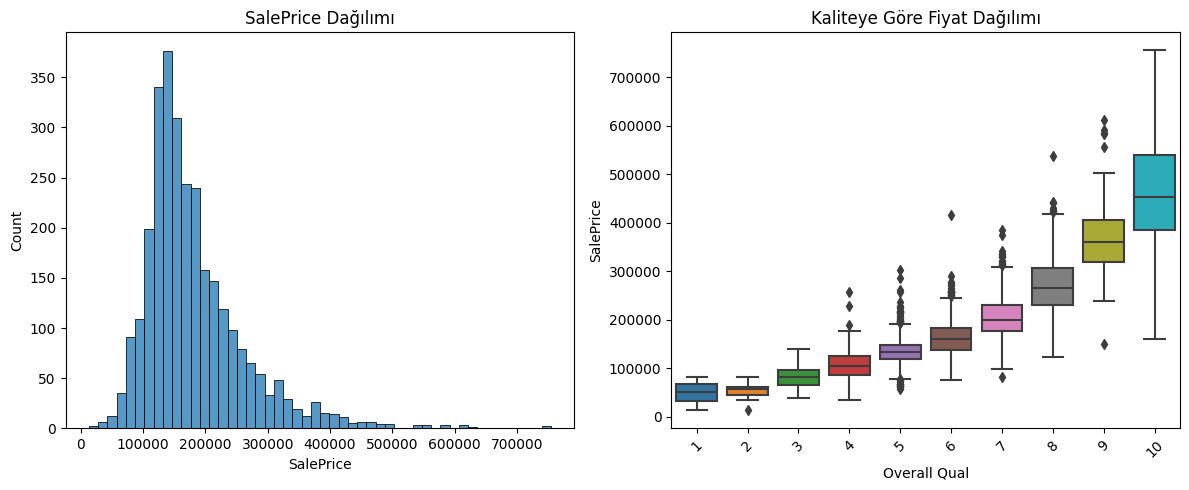

In [16]:
# 1. Veri seti boyutu ve genel bilgiler
print("1. VERİ SETİ GENEL BİLGİLERİ:")
print(f"Satır sayısı: {df_featured.shape[0]}")
print(f"Sütun sayısı: {df_featured.shape[1]}")

# 2. Kategorik ve sayısal değişken analizi
categorical_columns = df_featured.select_dtypes(include=['object', 'category']).columns
numerical_columns = df_featured.select_dtypes(include=['int64', 'float64']).columns

print("\n2. DEĞİŞKEN TİPLERİ ANALİZİ:")
print(f"Kategorik değişken sayısı: {len(categorical_columns)}")
print(f"Sayısal değişken sayısı: {len(numerical_columns)}")

# 3. Kategorik değişkenlerin kardinalite analizi
print("\n3. KATEGORİK DEĞİŞKEN KARDİNALİTE ANALİZİ:")
for col in categorical_columns:
    unique_count = df_featured[col].nunique()
    print(f"{col}: {unique_count} unique değer")

# 4. Bellek kullanımı
memory_usage = df_featured.memory_usage(deep=True).sum() / 1024**2  # MB cinsinden
print(f"\n4. BELLEK KULLANIMI: {memory_usage:.2f} MB")

# 5. Veri seti dengesi analizi (SalePrice için)
print("\n5. SALE PRICE DAĞILIM ANALİZİ:")
price_quartiles = df_featured['SalePrice'].quantile([0.25, 0.5, 0.75])
print("Fiyat çeyreklikleri:")
print(price_quartiles)

# 6. Neighborhood bazlı gruplama analizi
print("\n6. MAHALLE BAZLI ANALİZ:")
neighborhood_counts = df_featured['Neighborhood'].value_counts()
print("Mahalle bazlı ev sayıları:")
print(neighborhood_counts)

# 7. Zaman bazlı analiz
print("\n7. ZAMAN ANALİZİ:")
year_counts = df_featured['Yr Sold'].value_counts().sort_index()
print("Yıllara göre satış sayıları:")
print(year_counts)

# 8. Ordinal değişken kontrolü
print("\n8. POTANSİYEL ORDİNAL DEĞİŞKENLER:")
ordinal_candidates = ['Overall Qual', 'Overall Cond', 'Kitchen Qual', 'Exter Qual', 'Bsmt Qual']
for col in ordinal_candidates:
    if col in df_featured.columns:
        print(f"\n{col} unique değerleri:")
        print(df_featured[col].value_counts().sort_index())

# 9. İşlem süresi tahmini için basit bir test
import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

print("\n9. İŞLEM SÜRESİ TAHMİNİ:")
X = df_featured[high_corr_features[:-1]]  # SalePrice hariç
y = df_featured['SalePrice']

start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
_ = cross_val_score(rf, X, y, cv=5)
end_time = time.time()

print(f"5-fold CV ile RandomForest süresi: {end_time - start_time:.2f} saniye")

# Görselleştirme: Fiyat dağılımı
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.histplot(df_featured['SalePrice'], bins=50)
plt.title('SalePrice Dağılımı')

plt.subplot(122)
sns.boxplot(x='Overall Qual', y='SalePrice', data=df_featured)
plt.title('Kaliteye Göre Fiyat Dağılımı')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Encoding analysis

KATEGORİK DEĞİŞKEN ANALİZİ:

Önerilen Encoding Stratejileri:
           Feature  Unique_Values  Missing_Values  Min_Samples  Max_Samples  \
8     Neighborhood             28               0            1          443   
43  OverallQualCat              3               0           57         1783   
21       Bsmt Qual              6               0            2         1283   
18      Exter Qual              4               0           35         1799   
30    Kitchen Qual              5               0            1         1494   
34   Garage Finish              4               0          159         1231   
20      Foundation              6               0            5         1310   
33     Garage Type              7               0           15         1731   
32    Fireplace Qu              6               0           43         1422   
27      Heating QC              5               0            3         1495   
24  BsmtFin Type 1              7               0           80        

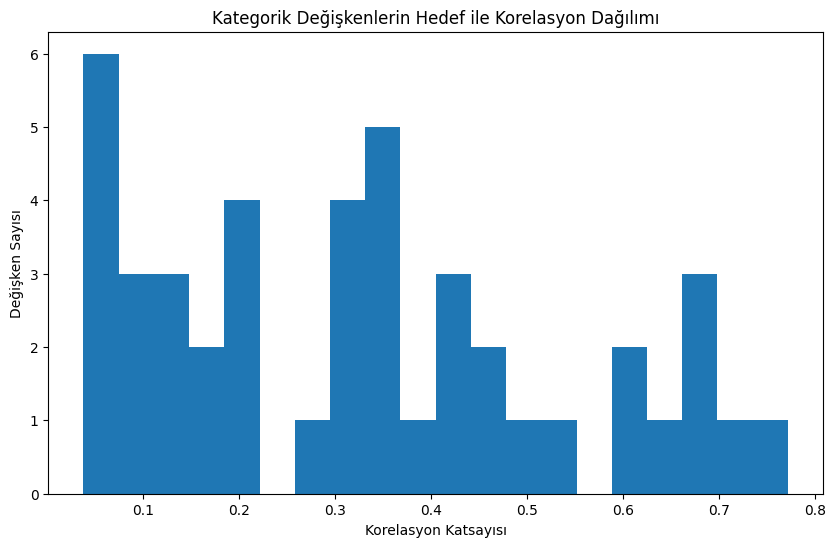

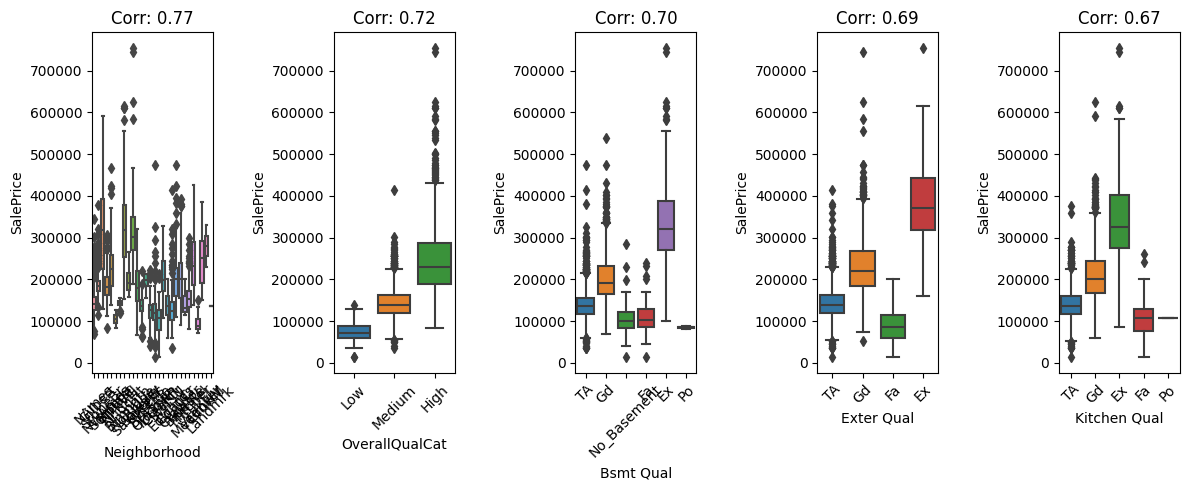

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Kategorik değişkenleri analiz eden fonksiyon
def analyze_categorical_features(df, target_col='SalePrice'):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    analysis_results = []
    
    for col in categorical_cols:
        # Temel istatistikler
        n_unique = df[col].nunique()
        n_missing = df[col].isnull().sum()
        
        # Ordinal olma olasılığını kontrol et
        # Sayısal bir sıralama ilişkisi var mı?
        try:
            # Her kategorinin ortalama hedef değerini hesapla
            category_means = df.groupby(col)[target_col].mean()
            # Kategorilerin sıralı versiyonu ile hedef arasındaki korelasyon
            correlation = spearmanr(
                df[col].map(category_means),
                df[target_col]
            )[0]
        except:
            correlation = np.nan
        
        # Her kategori için örnek sayısı
        value_counts = df[col].value_counts()
        min_samples = value_counts.min()
        max_samples = value_counts.max()
        
        # Önerilen encoding stratejisi
        if pd.api.types.is_numeric_dtype(df[col]):
            suggested_encoding = "Sayısal (encoding gerekmez)"
        elif n_unique <= 2:
            suggested_encoding = "Label Encoding (binary)"
        elif n_unique <= 10 and abs(correlation) > 0.5:
            suggested_encoding = "Label Encoding (ordinal)"
        elif n_unique <= 15:
            suggested_encoding = "One-Hot Encoding"
        else:
            suggested_encoding = "Target Encoding"
            
        analysis_results.append({
            'Feature': col,
            'Unique_Values': n_unique,
            'Missing_Values': n_missing,
            'Min_Samples': min_samples,
            'Max_Samples': max_samples,
            'Target_Correlation': correlation,
            'Suggested_Encoding': suggested_encoding
        })
    
    return pd.DataFrame(analysis_results)

# Analizi çalıştır
encoding_analysis = analyze_categorical_features(df_featured)

# Sonuçları görüntüle
print("KATEGORİK DEĞİŞKEN ANALİZİ:")
print("\nÖnerilen Encoding Stratejileri:")
print(encoding_analysis.sort_values('Target_Correlation', ascending=False))

# Encoding türlerine göre değişkenleri grupla
print("\nENCODING TÜRLERİNE GÖRE DEĞİŞKENLER:")
for encoding_type in encoding_analysis['Suggested_Encoding'].unique():
    features = encoding_analysis[encoding_analysis['Suggested_Encoding'] == encoding_type]['Feature'].tolist()
    print(f"\n{encoding_type}:")
    print(features)

# Korelasyon dağılımını görselleştir
plt.figure(figsize=(10, 6))
plt.hist(encoding_analysis['Target_Correlation'].dropna(), bins=20)
plt.title('Kategorik Değişkenlerin Hedef ile Korelasyon Dağılımı')
plt.xlabel('Korelasyon Katsayısı')
plt.ylabel('Değişken Sayısı')
plt.show()

# En yüksek korelasyonlu kategorik değişkenleri görselleştir
top_corr_features = encoding_analysis.nlargest(5, 'Target_Correlation')
plt.figure(figsize=(12, 5))
for i, (_, row) in enumerate(top_corr_features.iterrows(), 1):
    plt.subplot(1, 5, i)
    sns.boxplot(x=row['Feature'], y='SalePrice', data=df_featured)
    plt.xticks(rotation=45)
    plt.title(f'Corr: {row["Target_Correlation"]:.2f}')
plt.tight_layout()
plt.show()

### Encoding

In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
import pandas as pd
import numpy as np

# Veri setinin kopyasını oluştur
df_encoded = df_featured.copy()


# 1. Label Encoding (ordinal) için fonksiyon
def apply_ordinal_encoding(df, column, mapping):
    if column in df.columns:
        df[column] = df[column].map(mapping)
    return df


# Ordinal değişkenler için mapping (korelasyonu > 0.5 olanlar)
ordinal_mappings = {
    "OverallQualCat": {"Low": 0, "Medium": 1, "High": 2},  # 0.725
    "Bsmt Qual": {
        "No_Basement": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5,
    },  # 0.696
    "Exter Qual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},  # 0.687
    "Kitchen Qual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},  # 0.668
    "Garage Finish": {"No_Garage": 0, "Unf": 1, "RFn": 2, "Fin": 3},  # 0.626
    "Foundation": {
        "Slab": 0,
        "BrkTil": 1,
        "CBlock": 2,
        "Stone": 3,
        "Wood": 4,
        "PConc": 5,
    },  # 0.597
    "Garage Type": {
        "No_Garage": 0,
        "Detchd": 1,
        "CarPort": 2,
        "BuiltIn": 3,
        "Basment": 4,
        "Attchd": 5,
        "2Types": 6,
    },  # 0.595
    "Fireplace Qu": {
        "No_Fireplace": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5,
    },  # 0.547
    "Heating QC": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},  # 0.514
}

# 2. Binary encoding için değişkenler
binary_features = ["Street", "Central Air"]  # 0.068  # 0.331

# 3. Target encoding için değişkenler (yüksek korelasyonlu)
target_features = [
    "Neighborhood",  # 0.771
    "Exterior 1st",  # 0.444
    "Exterior 2nd",  # 0.433
]

# 4. One-hot encoding için değişkenler
onehot_features = [
    "MS Zoning",  # 0.434
    "Alley",  # 0.130
    "Lot Shape",  # 0.354
    "Land Contour",  # 0.166
    "Utilities",  # 0.038
    "Lot Config",  # 0.089
    "Land Slope",  # 0.058
    "Condition 1",  # 0.220
    "Condition 2",  # 0.106
    "Bldg Type",  # 0.203
    "House Style",  # 0.317
    "Roof Style",  # 0.187
    "Roof Matl",  # 0.069
    "Mas Vnr Type",  # 0.431
    "Exter Cond",  # 0.143
    "Bsmt Cond",  # 0.268
    "Bsmt Exposure",  # 0.371
    "BsmtFin Type 1",  # 0.474
    "BsmtFin Type 2",  # 0.155
    "Heating",  # 0.098
    "Electrical",  # 0.295
    "Functional",  # 0.132
    "Garage Qual",  # 0.365
    "Garage Cond",  # 0.351
    "Paved Drive",  # 0.337
    "Pool QC",  # 0.054
    "Fence",  # 0.211
    "Misc Feature",  # 0.060
    "Sale Type",  # 0.331
    "Sale Condition",  # 0.334
]

print("Encoding işlemleri başlıyor...")

# 1. Ordinal encoding
for col, mapping in ordinal_mappings.items():
    df_encoded = apply_ordinal_encoding(df_encoded, col, mapping)
    print(f"{col} için ordinal encoding tamamlandı")

# 2. Binary encoding
le = LabelEncoder()
for col in binary_features:
    if col in df_encoded.columns:
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        print(f"{col} için binary encoding tamamlandı")

# 3. Target encoding
te = TargetEncoder()
if all(col in df_encoded.columns for col in target_features):
    df_encoded[target_features] = te.fit_transform(
        df_encoded[target_features], df_encoded["SalePrice"]
    )
    print("Target encoding tamamlandı")

# 4. One-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=onehot_features, drop_first=True)
print("One-hot encoding tamamlandı")

# Encoding sonrası kontroller
print("\nEncoding öncesi shape:", df_featured.shape)
print("Encoding sonrası shape:", df_encoded.shape)

# Korelasyon kontrolü
numeric_cols = df_encoded.select_dtypes(include=["int64", "float64"]).columns
correlations = df_encoded[numeric_cols].corr()["SalePrice"].sort_values(ascending=False)
print("\nSalePrice ile en yüksek korelasyona sahip encoded özellikler (Top 15):")
print(correlations.head(15))

# Encoding sonrası eksik değer kontrolü
missing_after = df_encoded.isnull().sum()
if missing_after.sum() > 0:
    print("\nEncoding sonrası kalan eksik değerler:")
    print(missing_after[missing_after > 0])
else:
    print("\nEncoding sonrası eksik değer kalmadı!")

Encoding işlemleri başlıyor...
OverallQualCat için ordinal encoding tamamlandı
Bsmt Qual için ordinal encoding tamamlandı
Exter Qual için ordinal encoding tamamlandı
Kitchen Qual için ordinal encoding tamamlandı
Garage Finish için ordinal encoding tamamlandı
Foundation için ordinal encoding tamamlandı
Garage Type için ordinal encoding tamamlandı
Fireplace Qu için ordinal encoding tamamlandı
Heating QC için ordinal encoding tamamlandı
Street için binary encoding tamamlandı
Central Air için binary encoding tamamlandı
Target encoding tamamlandı
One-hot encoding tamamlandı

Encoding öncesi shape: (2930, 98)
Encoding sonrası shape: (2930, 212)

SalePrice ile en yüksek korelasyona sahip encoded özellikler (Top 15):
SalePrice              1.000000
QualitySize            0.845441
Location_Quality       0.835581
Overall Qual           0.799262
TotalSF                0.793127
Neighborhood           0.754767
Gr Liv Area            0.706780
NeighborhoodPriceSF    0.698447
Exter Qual             0.

### Model
### XGBoost
### LightGBM
### CatBoost
### With Cross Validation and custom hyperparameter

Veri seti boyutları:
X shape: (2930, 211)
y shape: (2930,)

Model eğitimi başlıyor...

XGBoost modeli değerlendiriliyor...
R2 Score: 0.9201 (+/- 0.0271)
RMSE: $22,453.97 (+/- $3,495.92)

LightGBM modeli değerlendiriliyor...
R2 Score: 0.9201 (+/- 0.0316)
RMSE: $22,422.00 (+/- $4,202.91)

Tüm Model Performansları:
          R2 Score    R2 Std          RMSE     RMSE Std
XGBoost   0.920094  0.013546  22453.974462  1747.957700
LightGBM  0.920149  0.015816  22421.998171  2101.454423


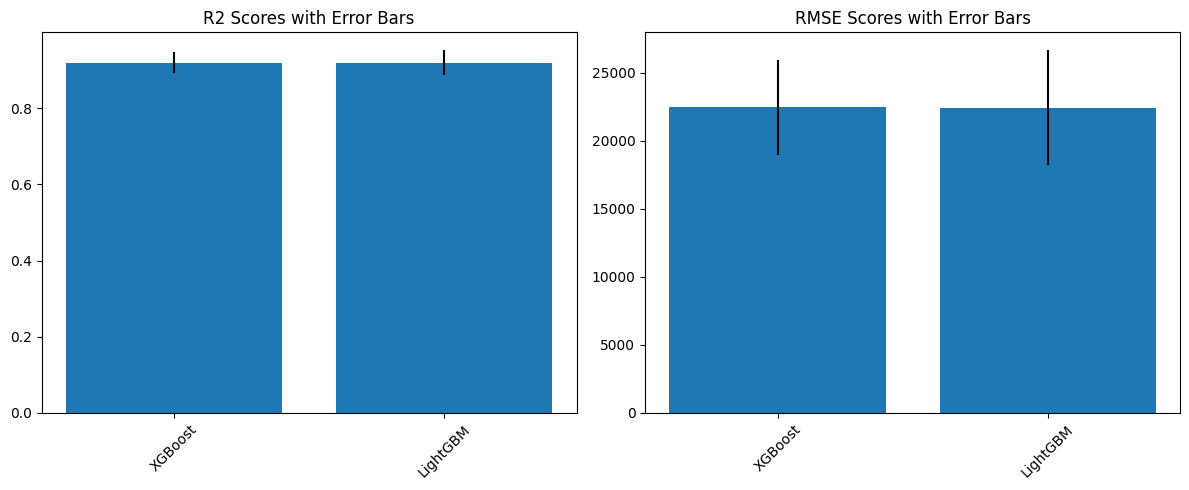


En iyi model: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6323
[LightGBM] [Info] Number of data points in the train set: 2930, number of used features: 157
[LightGBM] [Info] Start training from score 180796.060068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

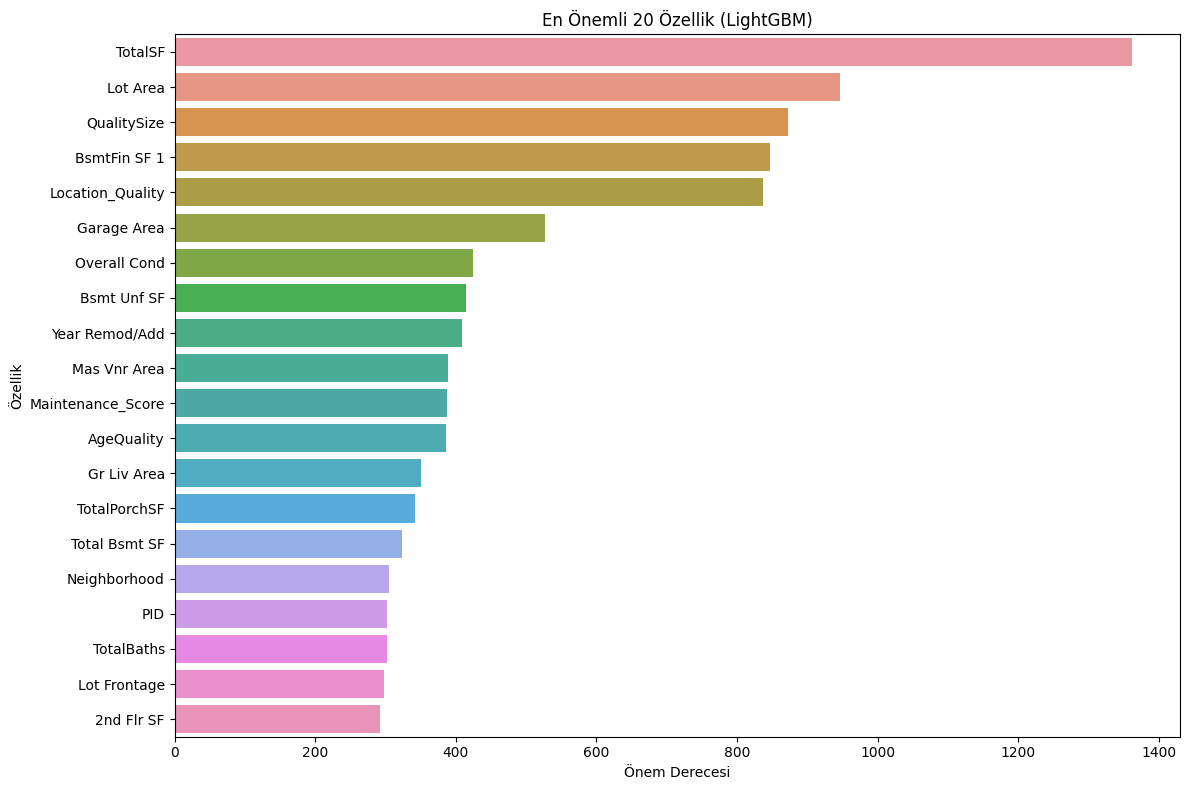


En önemli 20 özellik:
|    | feature           |   importance |
|---:|:------------------|-------------:|
| 51 | TotalSF           |         1362 |
|  4 | Lot Area          |          947 |
| 60 | QualitySize       |          873 |
| 17 | BsmtFin SF 1      |          847 |
| 65 | Location_Quality  |          837 |
| 41 | Garage Area       |          527 |
|  8 | Overall Cond      |          425 |
| 19 | Bsmt Unf SF       |          414 |
| 10 | Year Remod/Add    |          409 |
| 13 | Mas Vnr Area      |          389 |
| 66 | Maintenance_Score |          388 |
| 61 | AgeQuality        |          386 |
| 26 | Gr Liv Area       |          350 |
| 59 | TotalPorchSF      |          342 |
| 20 | Total Bsmt SF     |          324 |
|  6 | Neighborhood      |          305 |
|  1 | PID               |          302 |
| 56 | TotalBaths        |          302 |
|  3 | Lot Frontage      |          298 |
| 24 | 2nd Flr SF        |          292 |


In [23]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi hazırla (encoding işlemlerinden sonra)
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Kategorik sütunları numerik yapma
categorical_columns = X.select_dtypes(include=["category"]).columns
for col in categorical_columns:
    X[col] = X[col].astype("int64")
    
    
print("Veri seti boyutları:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Cross-validation için KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Model parametreleri
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 5,
    'random_state': 42,
    'n_jobs': -1
}

lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 5,
    'random_state': 42,
    'n_jobs': -1
}

# Modelleri tanımla
models = {
    "XGBoost": XGBRegressor(**xgb_params),
    "LightGBM": LGBMRegressor(**lgb_params)
}

# Sonuçları saklamak için dictionary
results = {}

print("\nModel eğitimi başlıyor...")

for name, model in models.items():
    print(f"\n{name} modeli değerlendiriliyor...")
    
    # R2 için cross-validation
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring="r2", n_jobs=-1)
    
    # RMSE için cross-validation
    rmse_scores = np.sqrt(
        -cross_val_score(
            model, X, y, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1
        )
    )
    
    results[name] = {
        "R2 Score": cv_scores.mean(),
        "R2 Std": cv_scores.std(),
        "RMSE": rmse_scores.mean(),
        "RMSE Std": rmse_scores.std(),
    }
    
    print(f"R2 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"RMSE: ${rmse_scores.mean():,.2f} (+/- ${rmse_scores.std()*2:,.2f})")

# Sonuçları DataFrame'e dönüştür
results_df = pd.DataFrame(results).T
print("\nTüm Model Performansları:")
print(results_df)

# Görselleştirme
plt.figure(figsize=(12, 5))

# R2 Scores
plt.subplot(121)
plt.bar(results_df.index, results_df["R2 Score"], yerr=results_df["R2 Std"]*2)
plt.title("R2 Scores with Error Bars")
plt.xticks(rotation=45)

# RMSE Scores
plt.subplot(122)
plt.bar(results_df.index, results_df["RMSE"], yerr=results_df["RMSE Std"]*2)
plt.title("RMSE Scores with Error Bars")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# En iyi modeli seç ve feature importance analizi yap
best_model_name = results_df["R2 Score"].idxmax()
print(f"\nEn iyi model: {best_model_name}")

# En iyi modeli tüm veri setiyle eğit
best_model = models[best_model_name]
best_model.fit(X, y)

# Feature importance analizi
importance = best_model.feature_importances_
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importance
})
feature_importance = feature_importance.sort_values("importance", ascending=False)

# En önemli 20 özelliği görselleştir
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importance.head(20))
plt.title(f"En Önemli 20 Özellik ({best_model_name})")
plt.xlabel("Önem Derecesi")
plt.ylabel("Özellik")
plt.tight_layout()
plt.show()

# En önemli 20 özelliği yazdır
print("\nEn önemli 20 özellik:")
print(feature_importance.head(20).to_markdown())

### XGBoost with Cross Validation and custom hyperparameter
### LightGBM with Cross Validation and custom hyperparameter
### CatBoost with Cross Validation and custom hyperparameter
### 


Model değerlendirmesi başlıyor...

XGBoost modeli değerlendiriliyor...
Train R2: 0.9182 (+/- 0.0615)
Train RMSE: $22,249.09 (+/- $6,790.88)
Test R2: 0.9378
Test RMSE: $19,715.09

LightGBM modeli değerlendiriliyor...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6199
[LightGBM] [Info] Number of data points in the train set: 2109, number of used features: 183
[LightGBM] [Info] Start training from score 180405.732101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

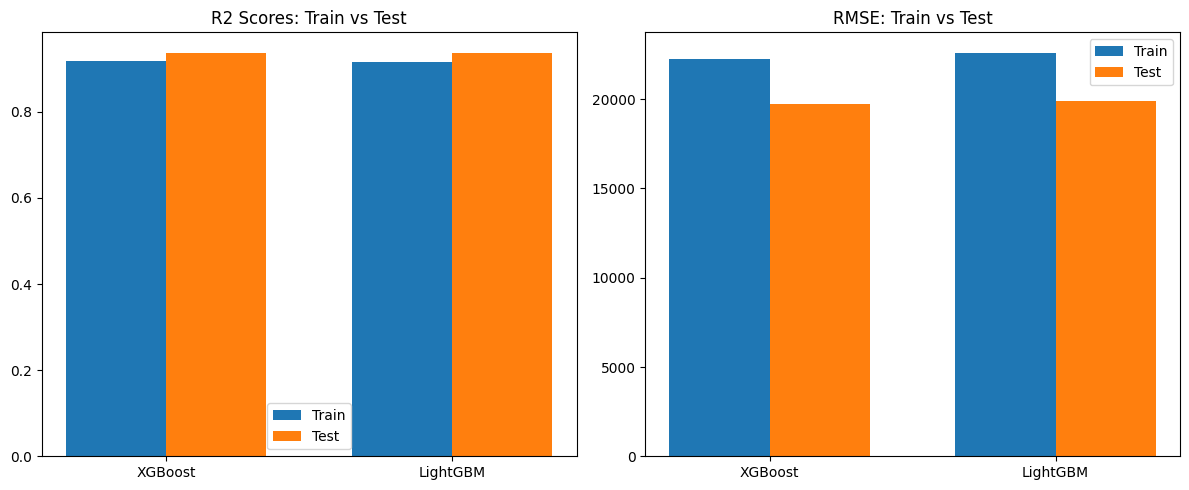

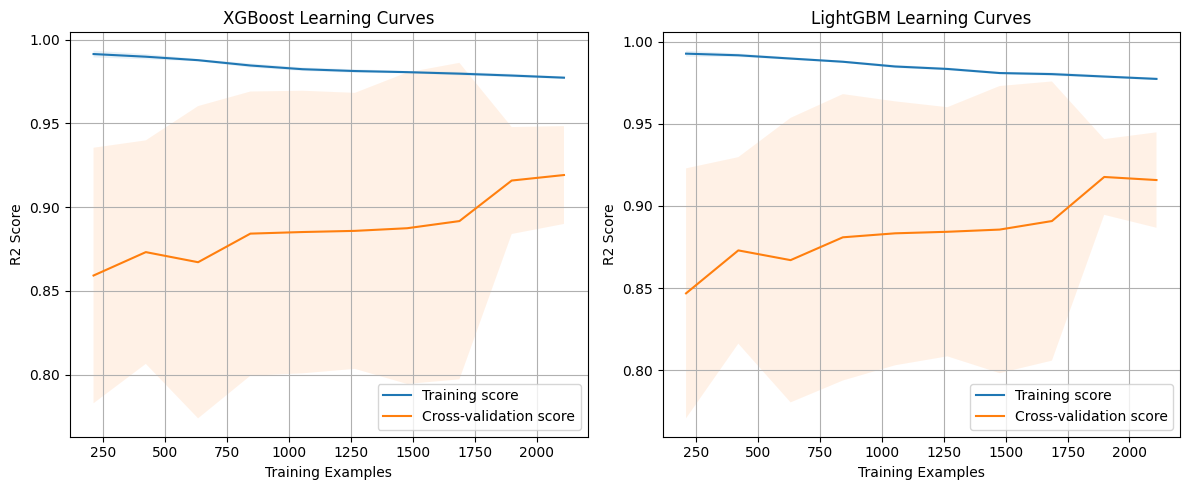

In [24]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi train ve test olarak ayır
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Kategorik sütunları numerik yapma
categorical_columns = X.select_dtypes(include=['category']).columns
for col in categorical_columns:
    X[col] = X[col].astype('int64')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Daha sıkı cross-validation (10-fold)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Model parametreleri (daha sıkı regularization)
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 4,  # Azaltıldı
    'min_child_weight': 5,  # Eklendi
    'subsample': 0.8,  # Eklendi
    'colsample_bytree': 0.8,  # Eklendi
    'reg_alpha': 0.1,  # L1 regularization
    'reg_lambda': 1.0,  # L2 regularization
    'random_state': 42
}

lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 4,  # Azaltıldı
    'min_child_samples': 5,  # Eklendi
    'subsample': 0.8,  # Eklendi
    'colsample_bytree': 0.8,  # Eklendi
    'reg_alpha': 0.1,  # L1 regularization
    'reg_lambda': 1.0,  # L2 regularization
    'random_state': 42
}

# Modelleri tanımla
models = {
    "XGBoost": XGBRegressor(**xgb_params),
    "LightGBM": LGBMRegressor(**lgb_params)
}

# Sonuçları saklamak için dictionary
results = {}

print("Model değerlendirmesi başlıyor...")

for name, model in models.items():
    print(f"\n{name} modeli değerlendiriliyor...")
    
    # Train üzerinde cross-validation
    cv_scores_train = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")
    rmse_scores_train = np.sqrt(-cross_val_score(
        model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"
    ))
    
    # Modeli tüm train seti üzerinde eğit
    model.fit(X_train, y_train)
    
    # Test seti üzerinde değerlendir
    y_pred_test = model.predict(X_test)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    results[name] = {
        "Train R2 Mean": cv_scores_train.mean(),
        "Train R2 Std": cv_scores_train.std(),
        "Train RMSE Mean": rmse_scores_train.mean(),
        "Train RMSE Std": rmse_scores_train.std(),
        "Test R2": r2_test,
        "Test RMSE": rmse_test
    }
    
    print(f"Train R2: {cv_scores_train.mean():.4f} (+/- {cv_scores_train.std()*2:.4f})")
    print(f"Train RMSE: ${rmse_scores_train.mean():,.2f} (+/- ${rmse_scores_train.std()*2:,.2f})")
    print(f"Test R2: {r2_test:.4f}")
    print(f"Test RMSE: ${rmse_test:,.2f}")

# Sonuçları DataFrame'e dönüştür
results_df = pd.DataFrame(results).T
print("\nTüm Model Performansları:")
print(results_df)

# Train vs Test performans karşılaştırması
plt.figure(figsize=(12, 5))

# R2 Scores
plt.subplot(121)
width = 0.35
x = np.arange(len(models))
plt.bar(x - width/2, results_df["Train R2 Mean"], width, label="Train")
plt.bar(x + width/2, results_df["Test R2"], width, label="Test")
plt.xticks(x, results_df.index)
plt.title("R2 Scores: Train vs Test")
plt.legend()

# RMSE Scores
plt.subplot(122)
plt.bar(x - width/2, results_df["Train RMSE Mean"], width, label="Train")
plt.bar(x + width/2, results_df["Test RMSE"], width, label="Test")
plt.xticks(x, results_df.index)
plt.title("RMSE: Train vs Test")
plt.legend()

plt.tight_layout()
plt.show()

# Learning curves
def plot_learning_curves(model, X_train, y_train, kf):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train, y_train,
        train_sizes=train_sizes,
        cv=kf,
        scoring='r2',
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.plot(train_sizes_abs, train_mean, label='Training score')
    plt.plot(train_sizes_abs, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('R2 Score')
    plt.legend(loc='best')
    plt.grid(True)

# Learning curves için görselleştirme
from sklearn.model_selection import learning_curve

plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_learning_curves(models["XGBoost"], X_train, y_train, kf)
plt.title("XGBoost Learning Curves")

plt.subplot(122)
plot_learning_curves(models["LightGBM"], X_train, y_train, kf)
plt.title("LightGBM Learning Curves")

plt.tight_layout()
plt.show()

* XGBoost with Cross Validation and custom hyperparameter
* LightGBM with Cross Validation and custom hyperparameter
* CatBoost with Cross Validation and custom hyperparameter
* Ensemble model


In [42]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb


# Veriyi hazırla
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Kategorik sütunları numerik yapma
categorical_columns = X.select_dtypes(include=["category"]).columns
for col in categorical_columns:
    X[col] = X[col].astype("int64")

# Train-validation-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print("Veri seti boyutları:")
print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Ortalama ev fiyatını hesapla
mean_price = y.mean()
print(f"\nOrtalama Ev Fiyatı: ${mean_price:,.2f}")

# Model parametreleri aynı kalacak
xgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "max_depth": 4,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 1.0,
    "random_state": 42,
    "n_jobs": -1,
}

lgb_params = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "max_depth": 4,
    "min_child_samples": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 1.0,
    "random_state": 42,
    "n_jobs": -1,
}

cat_params = {
    "iterations": 1000,
    "learning_rate": 0.01,
    "depth": 4,
    "min_data_in_leaf": 5,
    "subsample": 0.8,
    "colsample_bylevel": 0.8,
    "reg_lambda": 1.0,
    "random_state": 42,
    "verbose": False,
    "thread_count": -1,
}


# Her model için eğitim fonksiyonu
def train_model(model, name, X_train, y_train, X_val, y_val):
    if name == "XGBoost":
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=50,
            verbose=False,
        )
    elif name == "LightGBM":
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )
    elif name == "CatBoost":
        model.fit(
            X_train,
            y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            verbose=False,
        )
    return model


# Modelleri tanımla
models = {
    "XGBoost": XGBRegressor(**xgb_params),
    "LightGBM": LGBMRegressor(**lgb_params),
    "CatBoost": CatBoostRegressor(**cat_params),
}

# Her model için tahminleri saklamak için
train_predictions = {}
val_predictions = {}
test_predictions = {}
model_scores = {}

print("\nModel eğitimi ve değerlendirmesi başlıyor...")

# Her modeli eğit ve değerlendir
for name, model in models.items():
    print(f"\n{name} modeli eğitiliyor...")

    # Modeli eğit
    model = train_model(model, name, X_train, y_train, X_val, y_val)

    # Tahminleri al
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    # Tahminleri sakla
    train_predictions[name] = train_pred
    val_predictions[name] = val_pred
    test_predictions[name] = test_pred

    # Skorları hesapla
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    test_r2 = r2_score(y_test, test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    model_scores[name] = {
        "Train R2": train_r2,
        "Val R2": val_r2,
        "Test R2": test_r2,
        "Train RMSE": train_rmse,
        "Val RMSE": val_rmse,
        "Test RMSE": test_rmse,
    }

    print(f"Train R2: {train_r2:.4f}")
    print(f"Val R2: {val_r2:.4f}")
    print(f"Test R2: {test_r2:.4f}")
    print(f"Train RMSE: ${train_rmse:,.2f}")
    print(f"Val RMSE: ${val_rmse:,.2f}")
    print(f"Test RMSE: ${test_rmse:,.2f}")

# Sonuçları yazdırırken RMSE'yi ortalama fiyata oranla göster
for name, scores in model_scores.items():
    print(f"\n{name} Model Performansı:")
    print(f"Train R2: {scores['Train R2']:.4f}")
    print(f"Val R2: {scores['Val R2']:.4f}")
    print(f"Test R2: {scores['Test R2']:.4f}")
    print(f"Train RMSE: ${scores['Train RMSE']:,.2f} ({scores['Train RMSE']/mean_price*100:.1f}% of mean price)")
    print(f"Val RMSE: ${scores['Val RMSE']:,.2f} ({scores['Val RMSE']/mean_price*100:.1f}% of mean price)")
    print(f"Test RMSE: ${scores['Test RMSE']:,.2f} ({scores['Test RMSE']/mean_price*100:.1f}% of mean price)")

Veri seti boyutları:
Train set: (1875, 211)
Validation set: (469, 211)
Test set: (586, 211)

Ortalama Ev Fiyatı: $180,796.06

Model eğitimi ve değerlendirmesi başlıyor...

XGBoost modeli eğitiliyor...


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Train R2: 0.9790
Val R2: 0.9299
Test R2: 0.9385
Train RMSE: $11,614.94
Val RMSE: $21,023.58
Test RMSE: $19,613.18

LightGBM modeli eğitiliyor...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6126
[LightGBM] [Info] Number of data points in the train set: 1875, number of used features: 178
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 180090.687467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

### Feature importance for each model

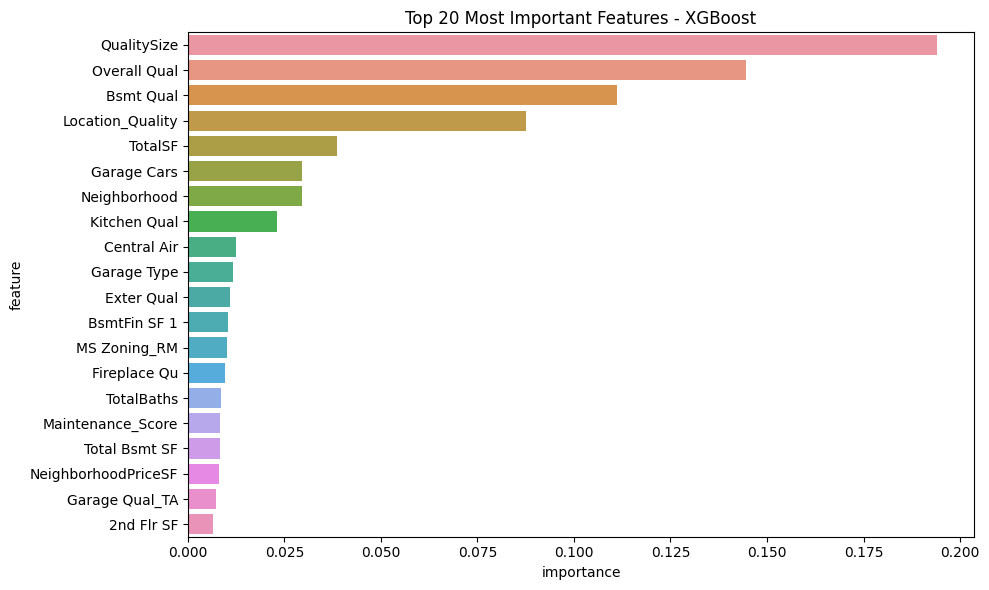

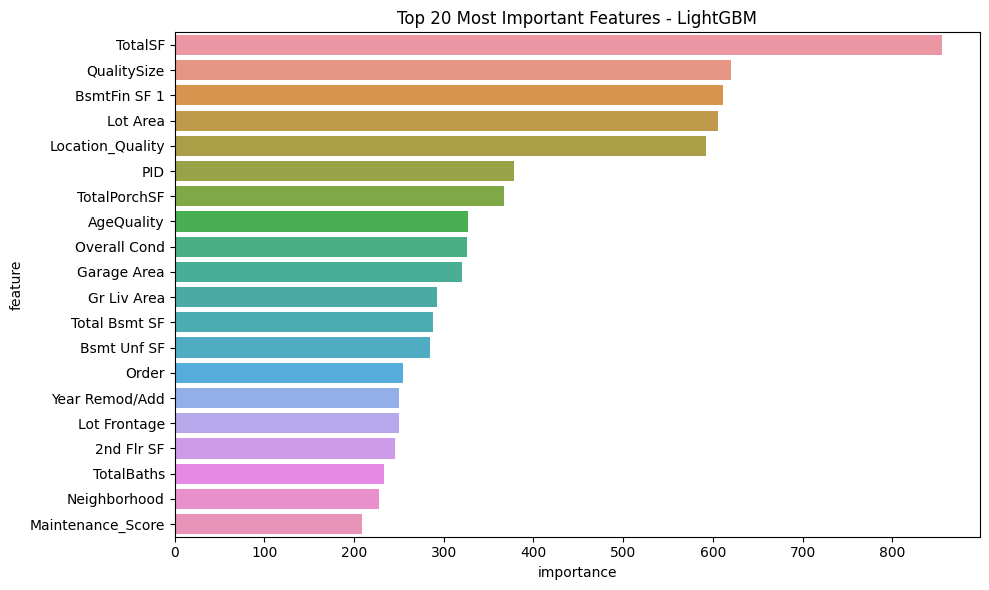

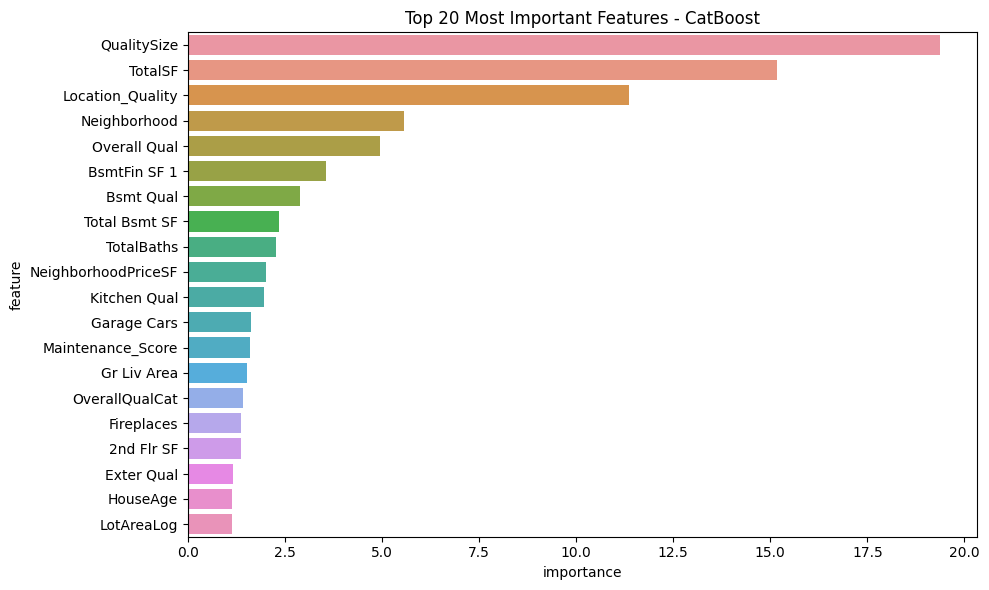

In [26]:
# En önemli özellikleri görselleştir
def plot_feature_importance(model, name):
    if hasattr(model, "feature_importances_"):
        importance = pd.DataFrame(
            {"feature": X.columns, "importance": model.feature_importances_}
        ).sort_values("importance", ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance.head(20), x="importance", y="feature")
        plt.title(f"Top 20 Most Important Features - {name}")
        plt.tight_layout()
        plt.show()


for name, model in models.items():
    plot_feature_importance(model, name)

### Stacking model
### Stacking model with cross validation and custom hyperparameter


In [28]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np


# 1. Özelleştirilmiş modeller için fonksiyon
def train_specialized_models(X, y):
    # Fiyat segmentlerine göre veriyi böl
    price_quantiles = pd.qcut(
        y, q=4, labels=["low", "medium_low", "medium_high", "high"]
    )

    models = {}
    for segment in ["low", "medium_low", "medium_high", "high"]:
        mask = price_quantiles == segment

        # Her segment için ayrı model
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None if segment == "low" else 10,
            min_samples_leaf=10 if segment == "low" else 5,
            random_state=42,
        )

        model.fit(X[mask], y[mask])
        models[segment] = model

    return models


# 3. Stacking model için fonksiyon
def create_stacking_model():
    estimators = [
        ("rf", RandomForestRegressor(random_state=42)),
        ("gbm", LGBMRegressor(random_state=42)),
        ("xgb", XGBRegressor(random_state=42)),
    ]

    return StackingRegressor(
        estimators=estimators, final_estimator=LGBMRegressor(random_state=42)
    )


# Veriyi hazırla
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Fiyat aralıklarını oluştur
price_bins = pd.qcut(y, q=10, labels=False)

# Pipeline oluştur
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", create_stacking_model()),
    ]
)

# Grid Search parametreleri
param_grid = {
    "model__rf__max_depth": [10, 15],
    "model__rf__min_samples_leaf": [5, 10],
    "model__gbm__num_leaves": [31, 63],
    "model__xgb__max_depth": [3, 5],
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search ile en iyi parametreleri bul
grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring="r2", n_jobs=-1, verbose=1
)

print("Model eğitimi başlıyor...")
grid_search.fit(X, y)

# En iyi sonuçları göster
print("\nEn iyi parametreler:", grid_search.best_params_)
print("En iyi cross-validation skoru:", grid_search.best_score_)

# Özelleştirilmiş modelleri eğit
specialized_models = train_specialized_models(X, y)

# Her segment için performansı değerlendir
for segment, model in specialized_models.items():
    mask = (
        pd.qcut(y, q=4, labels=["low", "medium_low", "medium_high", "high"]) == segment
    )
    segment_score = model.score(X[mask], y[mask])
    print(f"\n{segment} segment R2 score: {segment_score:.4f}")

# Final model performansını göster
print("\nFinal Model Performansı:")
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=cv, scoring="r2")
print(f"Ortalama R2: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Model eğitimi başlıyor...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6452
[LightGBM] [Info] Number of data points in the train set: 2930, number of used features: 157
[LightGBM] [Info] Start training from score 180796.060068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6340
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 155
[LightGBM] [Info] Start training from score 186981.758959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6303
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 151
[LightGBM] [Info] Start training from score 180416.124573
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6208
[LightGBM] [Info] Number of data points in the train set: 1875, number of used features: 150
[LightGBM] [Info] Start training from score 186372.941867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

=== Segment Performans Analizi ===

low Segment:
Örnek Sayısı: 739
Ortalama Fiyat: $105,559.47
R2 Score: 0.7805
RMSE: $9,667.42
MAE: $7,155.78
MAPE: 8.59%

medium_low Segment:
Örnek Sayısı: 728
Ortalama Fiyat: $144,310.89
R2 Score: 0.7346
RMSE: $4,572.82
MAE: $3,698.47
MAPE: 2.57%

medium_high Segment:
Örnek Sayısı: 732
Ortalama Fiyat: $184,319.85
R2 Score: 0.8058
RMSE: $6,404.50
MAE: $5,076.29
MAPE: 2.75%

high Segment:
Örnek Sayısı: 731
Ortalama Fiyat: $289,662.85
R2 Score: 0.9296
RMSE: $20,441.48
MAE: $13,276.74
MAPE: 4.33%



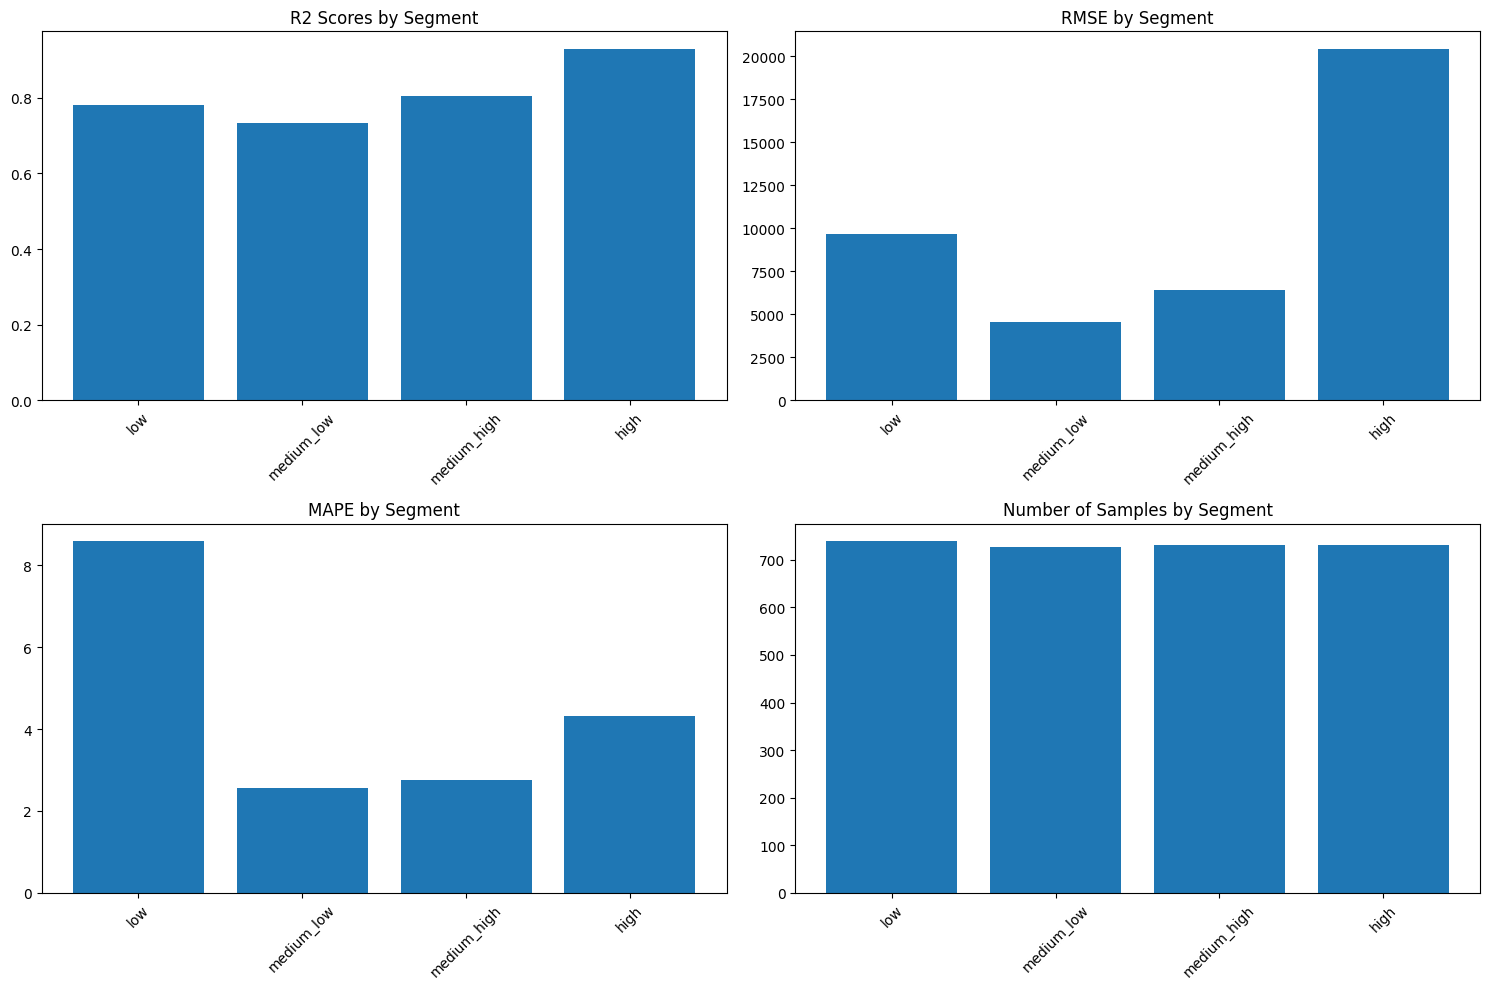

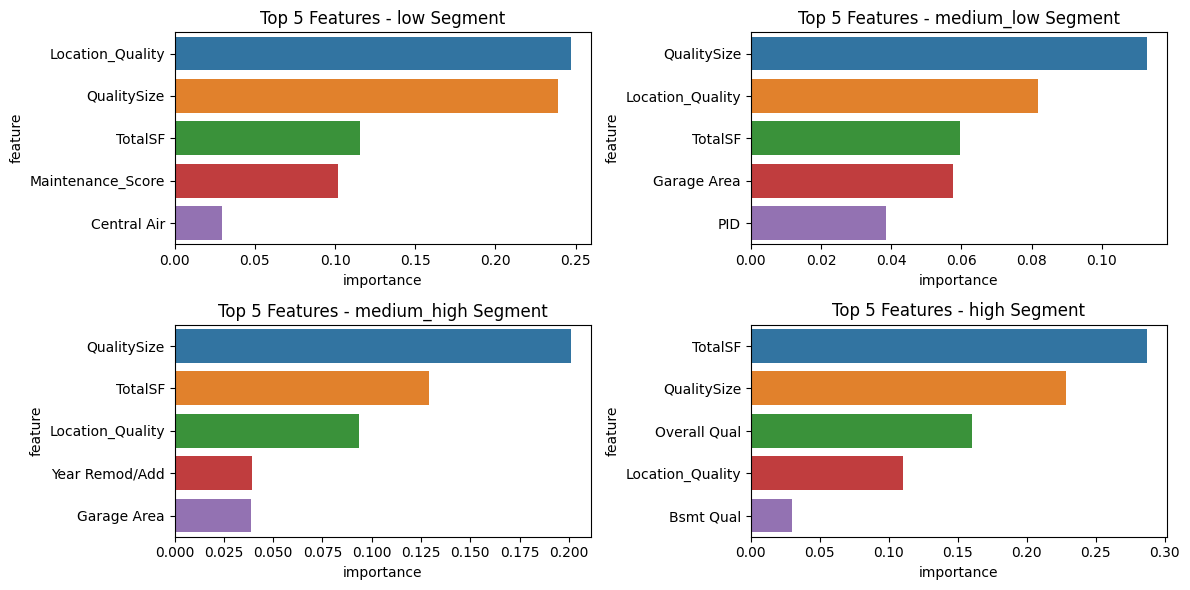

In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


# Segment performans analizi
def analyze_segment_performance(models, X, y):
    # Fiyat segmentlerine göre veriyi böl
    price_quantiles = pd.qcut(
        y, q=4, labels=["low", "medium_low", "medium_high", "high"]
    )

    segment_metrics = {}

    for segment, model in models.items():
        # Segment maskesi
        mask = price_quantiles == segment
        X_segment = X[mask]
        y_segment = y[mask]

        # Tahminler
        y_pred = model.predict(X_segment)

        # Metrikler
        rmse = np.sqrt(mean_squared_error(y_segment, y_pred))
        r2 = r2_score(y_segment, y_pred)
        mae = mean_absolute_error(y_segment, y_pred)
        mape = np.mean(np.abs((y_segment - y_pred) / y_segment)) * 100

        segment_metrics[segment] = {
            "RMSE": rmse,
            "R2": r2,
            "MAE": mae,
            "MAPE": mape,
            "Ortalama Fiyat": y_segment.mean(),
            "Örnek Sayısı": len(y_segment),
        }

    return segment_metrics

# Veriyi hazırla
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Segment performanslarını hesapla
segment_metrics = analyze_segment_performance(specialized_models, X, y)

# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(segment_metrics).T

# Metrikleri yazdır
print("=== Segment Performans Analizi ===\n")
for segment in results_df.index:
    print(f"{segment} Segment:")
    print(f"Örnek Sayısı: {results_df.loc[segment, 'Örnek Sayısı']:.0f}")
    print(f"Ortalama Fiyat: ${results_df.loc[segment, 'Ortalama Fiyat']:,.2f}")
    print(f"R2 Score: {results_df.loc[segment, 'R2']:.4f}")
    print(f"RMSE: ${results_df.loc[segment, 'RMSE']:,.2f}")
    print(f"MAE: ${results_df.loc[segment, 'MAE']:,.2f}")
    print(f"MAPE: {results_df.loc[segment, 'MAPE']:.2f}%")
    print()

# Görselleştirmeler
plt.figure(figsize=(15, 10))

# R2 Scores
plt.subplot(221)
plt.bar(results_df.index, results_df["R2"])
plt.title("R2 Scores by Segment")
plt.xticks(rotation=45)

# RMSE
plt.subplot(222)
plt.bar(results_df.index, results_df["RMSE"])
plt.title("RMSE by Segment")
plt.xticks(rotation=45)

# MAPE
plt.subplot(223)
plt.bar(results_df.index, results_df["MAPE"])
plt.title("MAPE by Segment")
plt.xticks(rotation=45)

# Örnek Sayısı
plt.subplot(224)
plt.bar(results_df.index, results_df["Örnek Sayısı"])
plt.title("Number of Samples by Segment")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Feature importance analizi
plt.figure(figsize=(12, 6))
for segment, model in specialized_models.items():
    importance = pd.DataFrame(
        {"feature": X.columns, "importance": model.feature_importances_}
    ).sort_values("importance", ascending=False)

    plt.subplot(2, 2, list(specialized_models.keys()).index(segment) + 1)
    sns.barplot(data=importance.head(5), x="importance", y="feature")
    plt.title(f"Top 5 Features - {segment} Segment")

plt.tight_layout()
plt.show()

* Veriyi train-test olarak ayırır
* Her segment için test setinde tahminler yapar
* Detaylı performans metrikleri gösterir
* Görselleştirmeler sunar:
* Tahmin vs Gerçek değer grafikleri
* Residual plotlar
* Hata dağılımları
* Yüzdelik hata analizleri yapar

=== Test Seti Tahmin Sonuçları ===

low Segment Test Sonuçları:
Örnek Sayısı: 147
Ortalama Fiyat: $104,683.30
R2 Score: 0.8132
RMSE: $8,604.65
MAE: $6,456.05
MAPE: 7.29%

medium_low Segment Test Sonuçları:
Örnek Sayısı: 147
Ortalama Fiyat: $143,330.33
R2 Score: 0.7728
RMSE: $4,442.00
MAE: $3,750.19
MAPE: 2.63%

medium_high Segment Test Sonuçları:
Örnek Sayısı: 147
Ortalama Fiyat: $183,067.54
R2 Score: 0.7225
RMSE: $7,739.36
MAE: $6,005.90
MAPE: 3.34%

high Segment Test Sonuçları:
Örnek Sayısı: 145
Ortalama Fiyat: $288,952.69
R2 Score: 0.9311
RMSE: $19,594.01
MAE: $13,247.27
MAPE: 4.38%



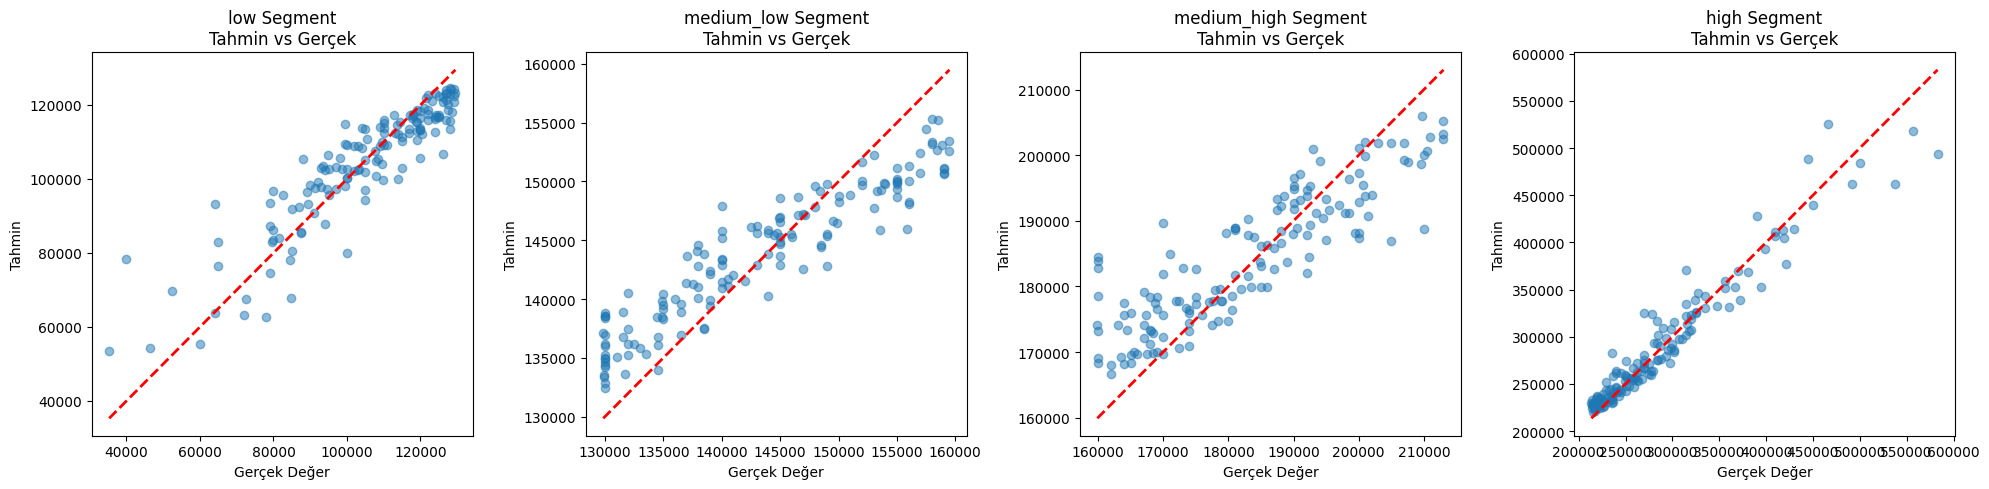

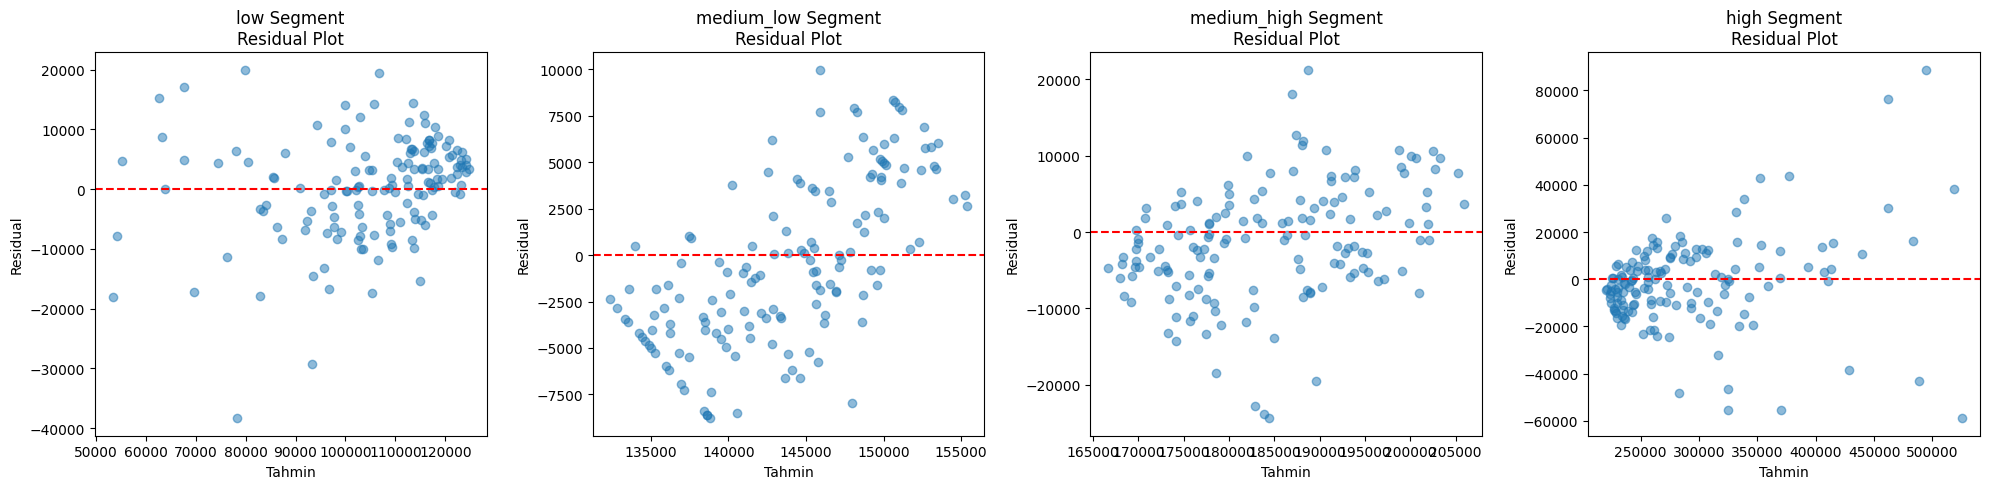

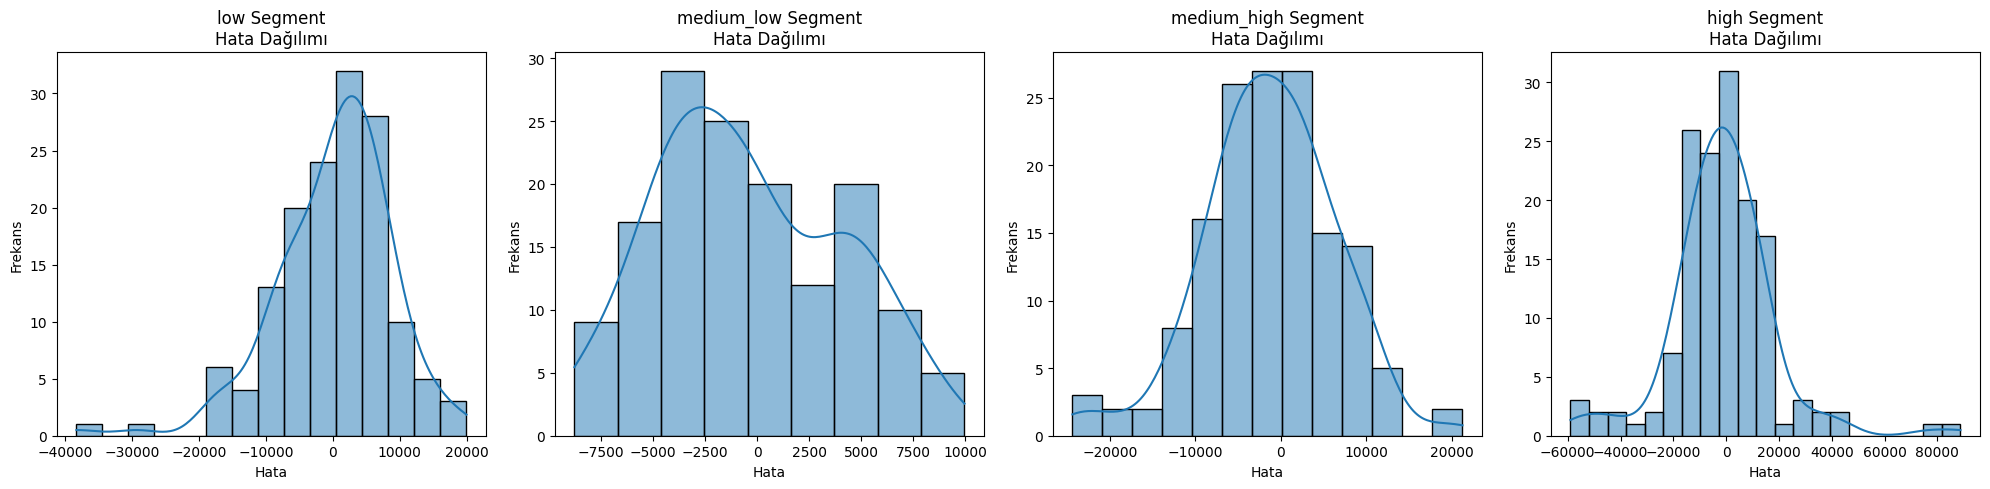


low Segment Hata Yüzdeleri:
Tahminlerin %90'ı ±15.41% hata payı içinde
Tahminlerin %95'i ±19.93% hata payı içinde

medium_low Segment Hata Yüzdeleri:
Tahminlerin %90'ı ±4.97% hata payı içinde
Tahminlerin %95'i ±5.60% hata payı içinde

medium_high Segment Hata Yüzdeleri:
Tahminlerin %90'ı ±6.73% hata payı içinde
Tahminlerin %95'i ±8.65% hata payı içinde

high Segment Hata Yüzdeleri:
Tahminlerin %90'ı ±9.49% hata payı içinde
Tahminlerin %95'i ±11.26% hata payı içinde


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Veriyi train-test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Her segment için tahmin yap
price_quantiles = pd.qcut(
    y_test, q=4, labels=["low", "medium_low", "medium_high", "high"]
)
predictions = {}
actual_values = {}

print("=== Test Seti Tahmin Sonuçları ===\n")

for segment, model in specialized_models.items():
    # Segment maskesi
    mask = price_quantiles == segment
    X_segment = X_test[mask]
    y_segment = y_test[mask]

    # Tahminler
    y_pred = model.predict(X_segment)
    predictions[segment] = y_pred
    actual_values[segment] = y_segment

    # Metrikler
    rmse = np.sqrt(mean_squared_error(y_segment, y_pred))
    r2 = r2_score(y_segment, y_pred)
    mae = mean_absolute_error(y_segment, y_pred)
    mape = np.mean(np.abs((y_segment - y_pred) / y_segment)) * 100

    print(f"{segment} Segment Test Sonuçları:")
    print(f"Örnek Sayısı: {len(y_segment)}")
    print(f"Ortalama Fiyat: ${y_segment.mean():,.2f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"MAE: ${mae:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print()

# Görselleştirmeler
plt.figure(figsize=(20, 5))

# Her segment için actual vs predicted plot
for i, segment in enumerate(specialized_models.keys(), 1):
    plt.subplot(1, 4, i)
    plt.scatter(actual_values[segment], predictions[segment], alpha=0.5)
    plt.plot(
        [actual_values[segment].min(), actual_values[segment].max()],
        [actual_values[segment].min(), actual_values[segment].max()],
        "r--",
        lw=2,
    )
    plt.xlabel("Gerçek Değer")
    plt.ylabel("Tahmin")
    plt.title(f"{segment} Segment\nTahmin vs Gerçek")

plt.tight_layout()
plt.show()

# Residual analizi
plt.figure(figsize=(20, 5))

for i, segment in enumerate(specialized_models.keys(), 1):
    residuals = actual_values[segment] - predictions[segment]

    plt.subplot(1, 4, i)
    plt.scatter(predictions[segment], residuals, alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Tahmin")
    plt.ylabel("Residual")
    plt.title(f"{segment} Segment\nResidual Plot")

plt.tight_layout()
plt.show()

# Hata dağılımı
plt.figure(figsize=(20, 5))

for i, segment in enumerate(specialized_models.keys(), 1):
    residuals = actual_values[segment] - predictions[segment]

    plt.subplot(1, 4, i)
    sns.histplot(residuals, kde=True)
    plt.xlabel("Hata")
    plt.ylabel("Frekans")
    plt.title(f"{segment} Segment\nHata Dağılımı")

plt.tight_layout()
plt.show()

# Yüzdelik hata analizi
for segment in specialized_models.keys():
    percent_error = (
        np.abs((actual_values[segment] - predictions[segment]) / actual_values[segment])
        * 100
    )
    print(f"\n{segment} Segment Hata Yüzdeleri:")
    print(
        f"Tahminlerin %90'ı ±{np.percentile(percent_error, 90):.2f}% hata payı içinde"
    )
    print(
        f"Tahminlerin %95'i ±{np.percentile(percent_error, 95):.2f}% hata payı içinde"
    )

* Polynomial

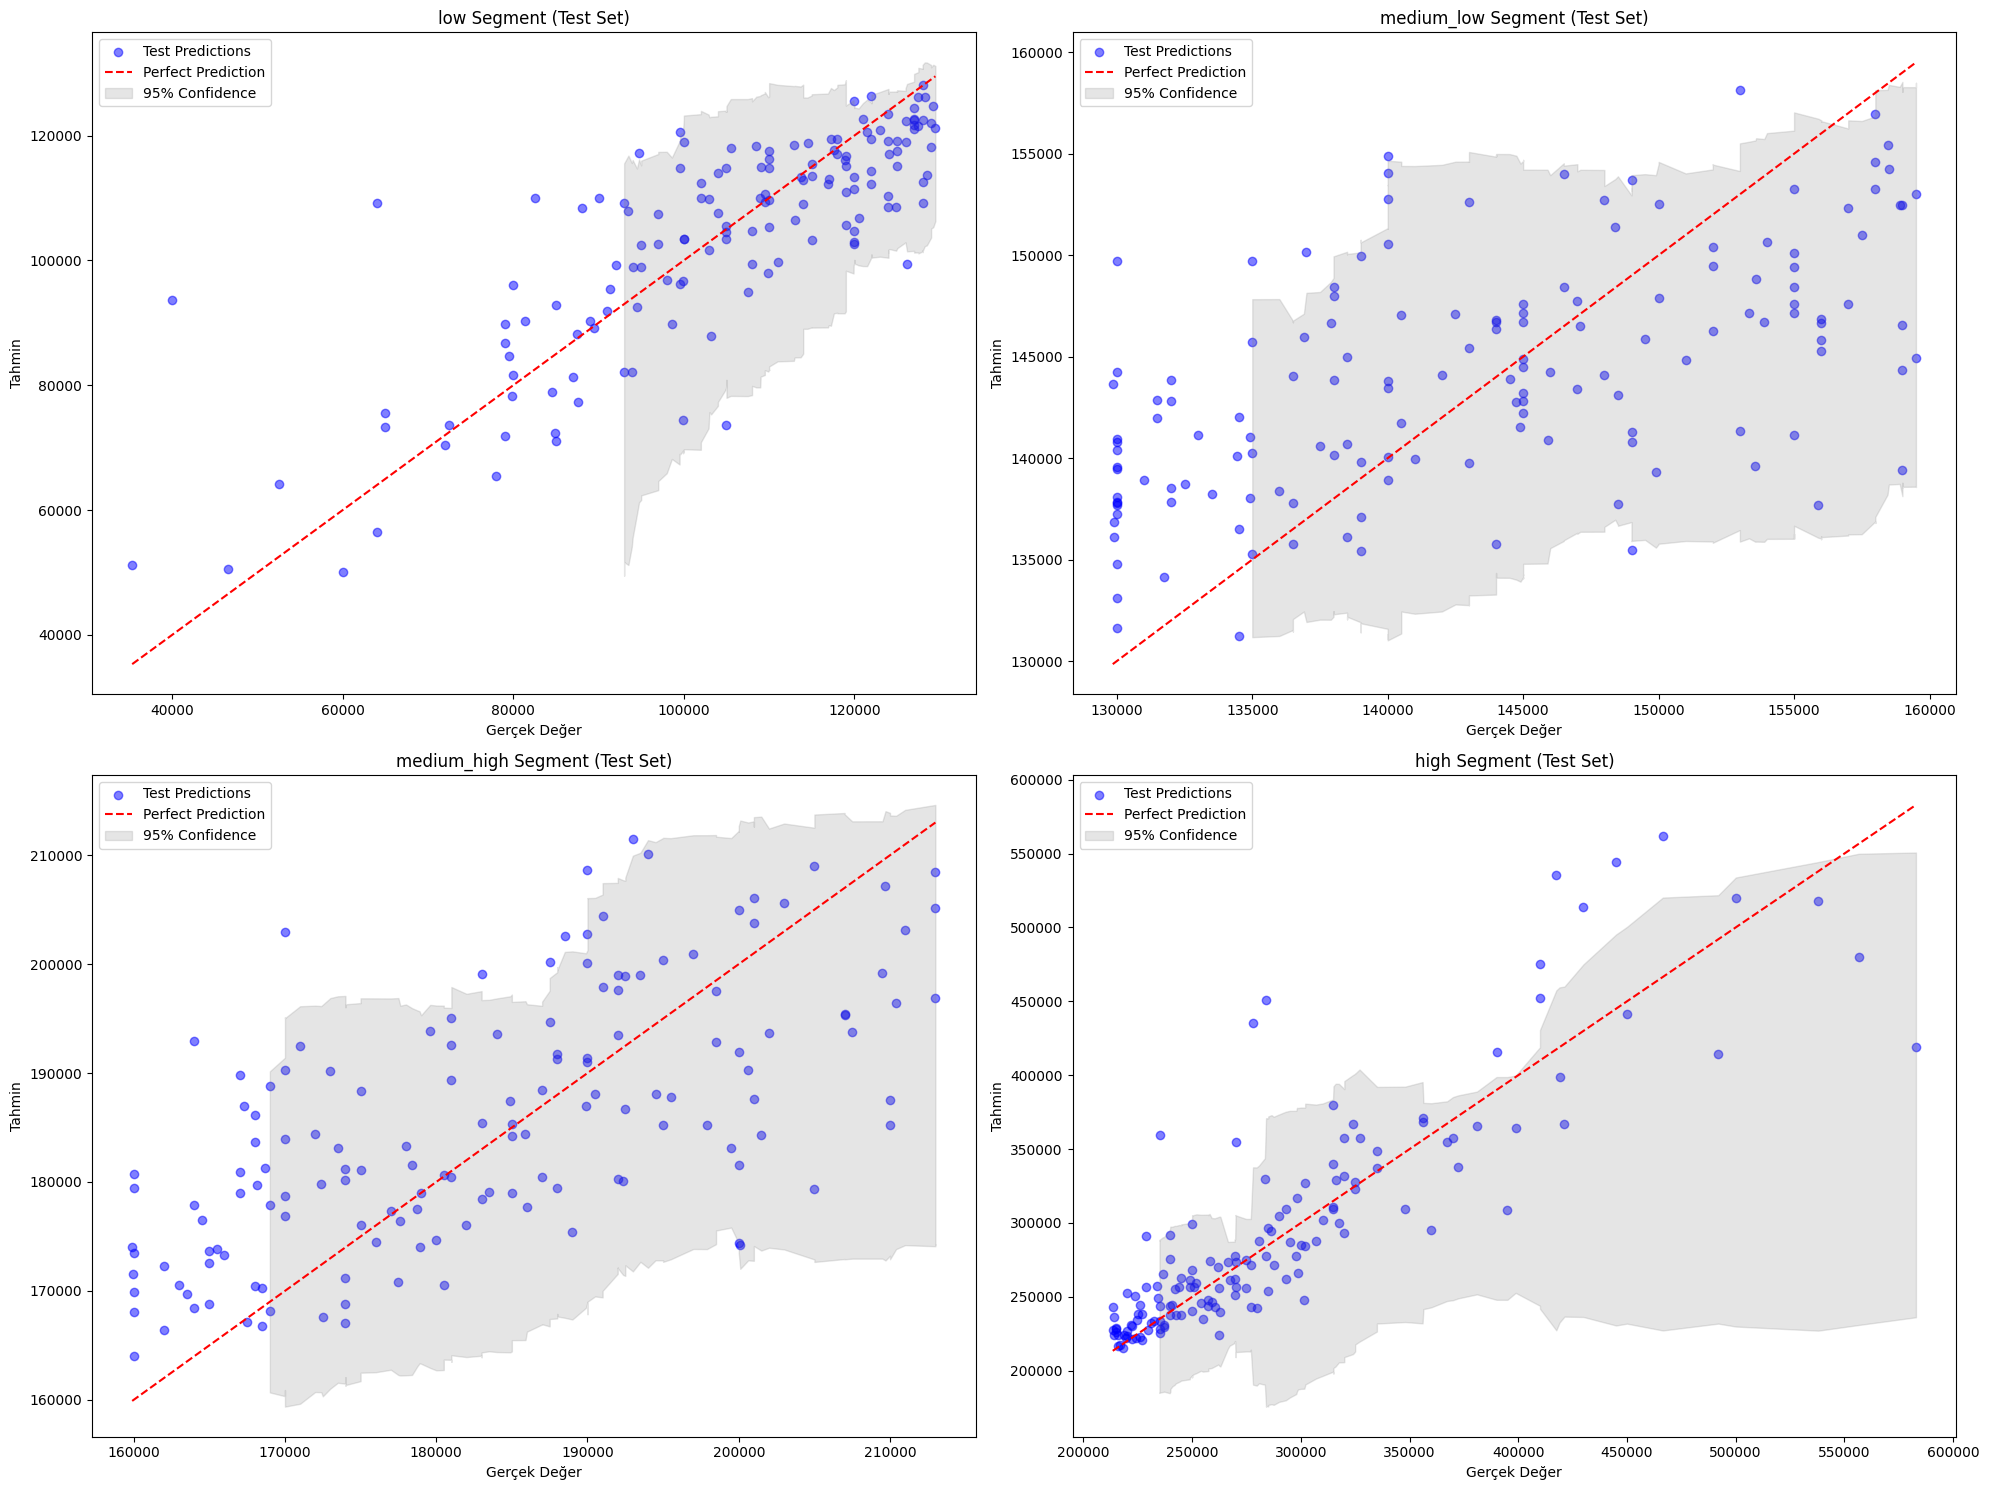

=== Test Seti Performans Metrikleri ===

low Segment:
Test Örnek Sayısı: 147
Ortalama Fiyat: $104,683.30
RMSE: $11,495.16
R2 Score: 0.6666
Residual std: $11,514.82
Tahminlerin %95'i ±$23,029.63 aralığında

medium_low Segment:
Test Örnek Sayısı: 147
Ortalama Fiyat: $143,330.33
RMSE: $7,667.82
R2 Score: 0.3229
Residual std: $7,646.41
Tahminlerin %95'i ±$15,292.82 aralığında

medium_high Segment:
Test Örnek Sayısı: 147
Ortalama Fiyat: $183,067.54
RMSE: $11,441.40
R2 Score: 0.3934
Residual std: $11,238.16
Tahminlerin %95'i ±$22,476.32 aralığında

high Segment:
Test Örnek Sayısı: 145
Ortalama Fiyat: $288,952.69
RMSE: $39,847.32
R2 Score: 0.7150
Residual std: $39,571.63
Tahminlerin %95'i ±$79,143.25 aralığında


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Önce train-test split yapalım
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Polynomial özellikler
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)  # Test için sadece transform

# Model parametreleri
complex_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    min_samples_leaf=9,
    min_samples_split=9,
    subsample=0.8,
    random_state=42,
)

# Her segment için ayrı model eğitelim
segment_models = {}
test_predictions = {}

# Train setinde segmentleri belirle
train_segments = pd.qcut(
    y_train, q=4, labels=["low", "medium_low", "medium_high", "high"]
)
test_segments = pd.qcut(
    y_test, q=4, labels=["low", "medium_low", "medium_high", "high"]
)

for segment in ["low", "medium_low", "medium_high", "high"]:
    # Train maskeleri
    train_mask = train_segments == segment
    test_mask = test_segments == segment

    # Model eğitimi
    model = complex_model.fit(X_train_poly[train_mask], y_train[train_mask])
    segment_models[segment] = model

    # Test seti tahminleri
    test_predictions[segment] = model.predict(X_test_poly[test_mask])

# Görselleştirme
plt.figure(figsize=(20, 15))
for i, segment in enumerate(segment_models.keys()):
    test_mask = test_segments == segment

    # Gerçek vs Tahmin (test seti için)
    plt.subplot(2, 2, i + 1)
    plt.scatter(
        y_test[test_mask],
        test_predictions[segment],
        alpha=0.5,
        c="blue",
        label="Test Predictions",
    )

    # Mükemmel tahmin çizgisi
    min_val = min(y_test[test_mask].min(), min(test_predictions[segment]))
    max_val = max(y_test[test_mask].max(), max(test_predictions[segment]))
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect Prediction")

    # Confidence interval
    sorted_idx = np.argsort(y_test[test_mask])
    sorted_y = y_test[test_mask].iloc[sorted_idx]
    sorted_pred = test_predictions[segment][sorted_idx]

    # Moving average ve std
    window = min(50, len(sorted_pred) // 4)  # Window size'ı veri boyutuna göre ayarla
    rolling_mean = pd.Series(sorted_pred).rolling(window=window).mean()
    rolling_std = pd.Series(sorted_pred).rolling(window=window).std()

    plt.fill_between(
        sorted_y,
        rolling_mean - 2 * rolling_std,
        rolling_mean + 2 * rolling_std,
        alpha=0.2,
        color="gray",
        label="95% Confidence",
    )

    plt.xlabel("Gerçek Değer")
    plt.ylabel("Tahmin")
    plt.title(f"{segment} Segment (Test Set)")
    plt.legend()

plt.tight_layout()
plt.show()

# Test seti performans metrikleri
print("=== Test Seti Performans Metrikleri ===")
for segment in segment_models.keys():
    test_mask = test_segments == segment

    mse = mean_squared_error(y_test[test_mask], test_predictions[segment])
    r2 = r2_score(y_test[test_mask], test_predictions[segment])

    print(f"\n{segment} Segment:")
    print(f"Test Örnek Sayısı: {sum(test_mask)}")
    print(f"Ortalama Fiyat: ${y_test[test_mask].mean():,.2f}")
    print(f"RMSE: ${np.sqrt(mse):,.2f}")
    print(f"R2 Score: {r2:.4f}")

    # Tahmin dağılımı
    residuals = y_test[test_mask] - test_predictions[segment]
    print(f"Residual std: ${residuals.std():,.2f}")
    print(f"Tahminlerin %95'i ±${2*residuals.std():,.2f} aralığında")

### Deep learning

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import StandardScaler

X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Veriyi ölçeklendir
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


# Basit MLP modeli
def create_mlp_model(input_dim):
    model = keras.Sequential(
        [
            layers.Dense(64, activation="relu", input_dim=input_dim),
            layers.Dropout(0.2),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(1),
        ]
    )

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


# Model eğitim süresi testi
import time

start_time = time.time()
model = create_mlp_model(X.shape[1])
model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
end_time = time.time()

print(f"Tek epoch eğitim süresi: {end_time - start_time:.2f} saniye")

Tek epoch eğitim süresi: 3.33 saniye


* MLP (Multi layer perceptron)

In [21]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Veriyi hazırla
X = df_encoded.drop("SalePrice", axis=1)
y = df_encoded["SalePrice"]

# Train-validation-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

# Ölçeklendirme
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


# Daha kapsamlı MLP modeli
def create_mlp_model(input_dim):
    model = keras.Sequential(
        [
            # İlk blok
            layers.Dense(128, input_dim=input_dim),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.Dropout(0.3),
            # İkinci blok
            layers.Dense(64),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.Dropout(0.2),
            # Üçüncü blok
            layers.Dense(32),
            layers.BatchNormalization(),
            layers.Activation("relu"),
            layers.Dropout(0.1),
            # Çıkış katmanı
            layers.Dense(1),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mae"],
    )
    return model


# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True,verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=10, min_lr=0.00001,
)

# Model eğitimi
model = create_mlp_model(X_train.shape[1])

print("Model eğitimi başlıyor...")
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=200,
    batch_size=64,  # Batch size artırıldı
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

# Tahminler ve metrikler için önceki kodlar aynı kalacak...

Model eğitimi başlıyor...
Epoch 1/200
30/30 [==============================] - 6s 27ms/step - loss: 0.9349 - mae: 0.6961 - val_loss: 0.3085 - val_mae: 0.4172 - lr: 0.0010
Epoch 2/200
30/30 [==============================] - 0s 13ms/step - loss: 0.5430 - mae: 0.5430 - val_loss: 0.2402 - val_mae: 0.3665 - lr: 0.0010
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.4421 - mae: 0.4769 - val_loss: 0.1962 - val_mae: 0.3313 - lr: 0.0010
Epoch 4/200
30/30 [==============================] - 0s 13ms/step - loss: 0.4157 - mae: 0.4507 - val_loss: 0.1855 - val_mae: 0.3167 - lr: 0.0010
Epoch 5/200
30/30 [==============================] - 0s 12ms/step - loss: 0.3426 - mae: 0.4098 - val_loss: 0.1735 - val_mae: 0.3091 - lr: 0.0010
Epoch 6/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2948 - mae: 0.3976 - val_loss: 0.1336 - val_mae: 0.2675 - lr: 0.0010
Epoch 7/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2886 - mae: 0.3896 - val_loss

* Model Performansını Değerlendirme:

In [26]:
# Tahminler
y_train_pred = scaler_y.inverse_transform(model.predict(X_train_scaled))
y_val_pred = scaler_y.inverse_transform(model.predict(X_val_scaled))
y_test_pred = scaler_y.inverse_transform(model.predict(X_test_scaled))


# Performans metrikleri
def evaluate_performance(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n{set_name} Set Performansı:")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: ${rmse:,.2f} ({rmse/y_true.mean()*100:.1f}% of mean price)")
    print(f"MAE: ${mae:,.2f}")
    
    return r2,rmse


evaluate_performance(y_train, y_train_pred, "Train")
evaluate_performance(y_val, y_val_pred, "Validation")
test_r2, test_rmse = evaluate_performance(y_test, y_test_pred, "Test")

19/19 [==============================] - 0s 3ms/step

Train Set Performansı:
R2 Score: 0.9331
RMSE: $20,746.25 (11.5% of mean price)
MAE: $13,385.44

Validation Set Performansı:
R2 Score: 0.9195
RMSE: $22,521.54 (12.2% of mean price)
MAE: $15,588.74

Test Set Performansı:
R2 Score: 0.9122
RMSE: $23,428.34 (13.0% of mean price)
MAE: $15,821.14


* Görselleştirmeler:

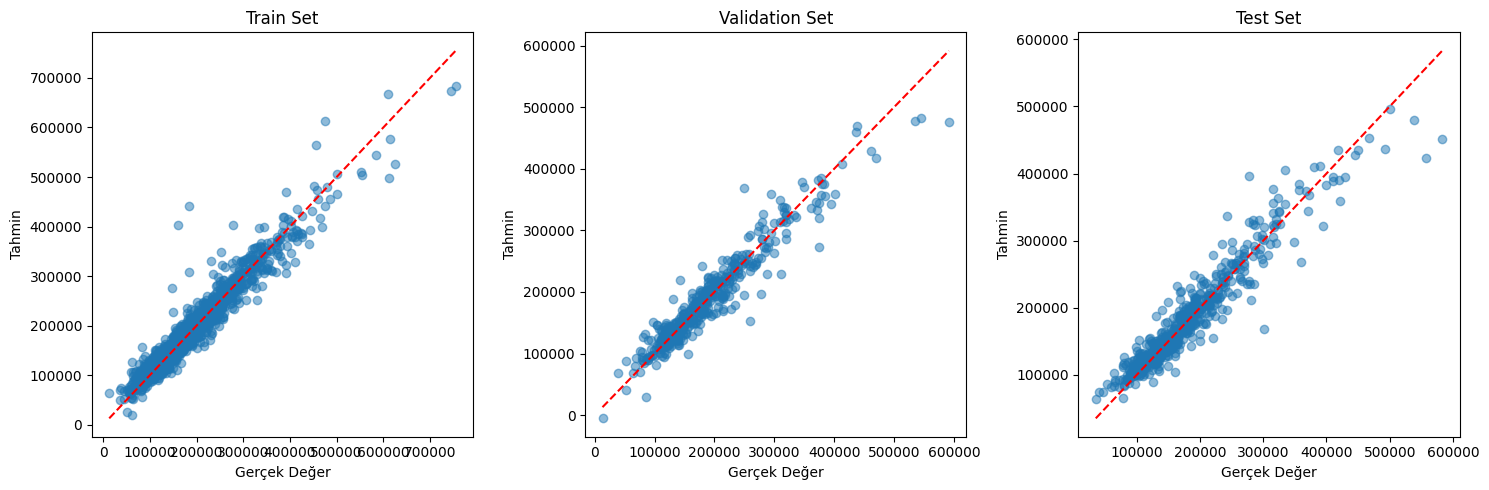

In [23]:
# Tahmin vs Gerçek değer karşılaştırması
plt.figure(figsize=(15, 5))

# Train, Validation ve Test setleri için scatter plotlar
plt.subplot(131)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--")
plt.xlabel("Gerçek Değer")
plt.ylabel("Tahmin")
plt.title("Train Set")

plt.subplot(132)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.xlabel("Gerçek Değer")
plt.ylabel("Tahmin")
plt.title("Validation Set")

plt.subplot(133)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Gerçek Değer")
plt.ylabel("Tahmin")
plt.title("Test Set")

plt.tight_layout()
plt.show()

In [27]:
# Tüm modellerin sonuçlarını bir DataFrame'de topla
results_df = pd.DataFrame(
    {
        "Model": ["XGBoost", "LightGBM", "CatBoost", "Deep Learning"],
        "Test R2": [0.9385, 0.9339, 0.9352, test_r2],
        "Test RMSE": [19613.18, 20334.59, 20130.80, test_rmse],
    }
)

print("\nModel Karşılaştırması:")
print(results_df)


Model Karşılaştırması:
           Model  Test R2     Test RMSE
0        XGBoost  0.93850  19613.180000
1       LightGBM  0.93390  20334.590000
2       CatBoost  0.93520  20130.800000
3  Deep Learning  0.91223  23428.335448
